# Predictive Equipment Maintenance Of Hydraulics System

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import random
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import StandardScaler


## Data Understanding

### Extracting Data from txt files
**First step** is to extract all sensors and components information into arrays and then transform it into a dataframe.  

#### Extracting Hydraulic System Sensors (independent variables)

In [2]:
import numpy as np

# Define the file paths and sensor names
sensor_files = {
    "ps": ["PS1.txt", "PS2.txt", "PS3.txt", "PS4.txt", "PS5.txt", "PS6.txt"], # pressure sensors
    "eps1": ["EPS1.txt"],    # motor power sensor
    "fs": ["FS1.txt", "FS2.txt"],   # volume flow sensors
    "ts": ["TS1.txt", "TS2.txt", "TS3.txt", "TS4.txt"],
    "vs1": ["VS1.txt"],  # vibration sensor
    "ce": ["CE.txt"],   # cooling efficiency (virtual) sensor
    "cp": ["CP.txt"],   # cooling power (virtual) sensor
    "se": ["SE.txt"]    # efficiency Factor sensor
}

# Base directory for the dataset
base_dir = "Dataset/"

# Dictionary to store the loaded sensor data
sensor_data = {}

# Load the data from the text files
for sensor_type, files in sensor_files.items():
    for i, file in enumerate(files):
        sensor_name = f"{sensor_type}{i+1}" if len(files) > 1 else sensor_type
        sensor_data[sensor_name] = np.genfromtxt(f"{base_dir}{file}")

In [3]:
# Dictionary to store the mean values
mean_values = {}

# Calculate the mean along axis 1 for all sensors
for sensor_name, data in sensor_data.items():
    mean_values[sensor_name] = data.mean(axis=1)

#### Extracting Hydraulic System Components (dependent variables)

In [4]:
# Extracting the Cooler condition, Valve condition, Internal pump leakage, 
#Hydraulic accumulator and Stable flag data from profile.txt file.
profile_arr=np.genfromtxt(r"Dataset/profile.txt")

### Data Framing
**Second Step** to put the extracted data for the sensors and components in data frames. 

#### Data Framing the Independent Variables

In [5]:
# Create a dictionary with the column names and corresponding mean values
df_data = {
    "PS1": mean_values["ps1"],
    "PS2": mean_values["ps2"],
    "PS3": mean_values["ps3"],
    "PS4": mean_values["ps4"],
    "PS5": mean_values["ps5"],
    "PS6": mean_values["ps6"],
    "EPS1": mean_values["eps1"],
    "FS1": mean_values["fs1"],
    "FS2": mean_values["fs2"],
    "TS1": mean_values["ts1"],
    "TS2": mean_values["ts2"],
    "TS3": mean_values["ts3"],
    "TS4": mean_values["ts4"],
    "VS1": mean_values["vs1"],
    "CE": mean_values["ce"],
    "CP": mean_values["cp"],
    "SE": mean_values["se"]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(df_data)

In [6]:
df.shape

(2205, 17)

In [7]:
df.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE
0,160.673492,109.466914,1.991475,0.0,9.842169,9.728098,2538.929167,6.709815,10.304592,35.621983,40.978767,38.471017,31.745250,0.576950,39.601350,1.862750,59.157183
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,41.532767,38.978967,34.493867,0.565850,25.786433,1.255550,59.335617
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,42.442450,39.631950,35.646150,0.576533,22.218233,1.113217,59.543150
3,160.188088,109.064807,1.946576,0.0,9.438827,9.337429,2511.541633,6.720565,10.302678,38.879050,43.403983,40.403383,36.579467,0.569267,20.459817,1.062150,59.794900
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,44.332750,41.310550,37.427900,0.577367,19.787017,1.070467,59.455267


#### Data Framing the Dependent Variables

In [8]:
profile_arr.shape

(2205, 5)

In [9]:
df_profile=pd.DataFrame(profile_arr,columns=["Cooler_Condition","Valve_Condition",
                                             "Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"])

In [10]:
df_profile.head()

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
0,3.0,100.0,0.0,130.0,1.0
1,3.0,100.0,0.0,130.0,1.0
2,3.0,100.0,0.0,130.0,1.0
3,3.0,100.0,0.0,130.0,1.0
4,3.0,100.0,0.0,130.0,1.0


#### Combining Both Dataframes

In [11]:
df_final=pd.concat([df,df_profile],axis=1)

In [12]:
df_final.head(10)

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,...,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
0,160.673492,109.466914,1.991475,0.0,9.842169,9.728098,2538.929167,6.709815,10.304592,35.621983,...,31.745250,0.576950,39.601350,1.862750,59.157183,3.0,100.0,0.0,130.0,1.0
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,...,34.493867,0.565850,25.786433,1.255550,59.335617,3.0,100.0,0.0,130.0,1.0
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,...,35.646150,0.576533,22.218233,1.113217,59.543150,3.0,100.0,0.0,130.0,1.0
3,160.188088,109.064807,1.946576,0.0,9.438827,9.337429,2511.541633,6.720565,10.302678,38.879050,...,36.579467,0.569267,20.459817,1.062150,59.794900,3.0,100.0,0.0,130.0,1.0
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,...,37.427900,0.577367,19.787017,1.070467,59.455267,3.0,100.0,0.0,130.0,1.0
5,159.920210,108.887682,1.913285,0.0,9.301160,9.206877,2501.007067,6.699023,10.178720,40.659450,...,38.212067,0.572683,19.149683,1.072083,59.563333,3.0,100.0,0.0,130.0,1.0
6,159.672675,108.676466,1.888100,0.0,9.233942,9.143320,2494.416900,6.698573,10.140810,41.463633,...,38.932100,0.573033,18.666383,1.081683,59.789900,3.0,100.0,0.0,130.0,1.0
7,159.614452,108.651745,1.874894,0.0,9.194159,9.105058,2489.421533,6.678027,10.095978,42.215267,...,39.558967,0.572000,18.178433,1.078700,59.590617,3.0,100.0,0.0,130.0,1.0
8,159.475745,108.529738,1.858120,0.0,9.144616,9.057067,2484.419067,6.671652,10.039710,42.891983,...,40.080533,0.567067,18.334867,1.115083,59.608883,3.0,100.0,0.0,130.0,1.0
9,159.437997,108.510885,1.841063,0.0,9.104831,9.019265,2480.434867,6.659990,9.997762,43.532833,...,40.612550,0.571683,18.205733,1.129133,59.473733,3.0,100.0,0.0,130.0,1.0


### Data Exploring

In [13]:
df_final.shape

(2205, 22)

In [14]:
df_final.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PS1                    2205 non-null   float64
 1   PS2                    2205 non-null   float64
 2   PS3                    2205 non-null   float64
 3   PS4                    2205 non-null   float64
 4   PS5                    2205 non-null   float64
 5   PS6                    2205 non-null   float64
 6   EPS1                   2205 non-null   float64
 7   FS1                    2205 non-null   float64
 8   FS2                    2205 non-null   float64
 9   TS1                    2205 non-null   float64
 10  TS2                    2205 non-null   float64
 11  TS3                    2205 non-null   float64
 12  TS4                    2205 non-null   float64
 13  VS1                    2205 non-null   float64
 14  CE                     2205 non-null   float64
 15  CP  

In [15]:
df_final.describe()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,...,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,160.485315,109.379906,1.753227,2.600266,9.163320,9.079363,2495.509203,6.198549,9.649453,45.424567,...,40.735654,0.613315,31.299077,1.808399,55.287900,41.240816,90.693878,0.669388,107.199546,0.342857
std,4.699425,4.986585,0.251902,4.279355,0.576296,0.549589,73.836682,1.032883,0.449246,7.991933,...,8.107878,0.060260,11.575330,0.278263,8.960189,42.383143,10.681802,0.817233,16.435848,0.474772
min,155.391547,104.406307,0.840252,0.000000,8.365801,8.321527,2361.747267,2.018572,8.857513,35.313783,...,30.390800,0.524367,17.555983,1.062150,18.276617,3.000000,73.000000,0.000000,90.000000,0.000000
25%,158.100195,106.962382,1.729733,0.000000,8.547239,8.487167,2442.933467,6.391670,9.203397,36.237150,...,31.272567,0.555100,20.084650,1.550100,56.270183,3.000000,80.000000,0.000000,90.000000,0.000000
50%,158.960895,107.730169,1.779631,0.000000,9.115781,9.031516,2480.926633,6.576673,9.692270,44.836650,...,40.429050,0.610183,27.392533,1.739683,58.758150,20.000000,100.000000,0.000000,100.000000,0.000000
75%,161.000735,109.421612,1.932047,3.503266,9.844351,9.729276,2548.211467,6.657508,10.155008,54.104317,...,49.409500,0.649850,46.677383,2.148483,59.656900,100.000000,100.000000,1.000000,130.000000,1.000000
max,180.922708,131.589089,2.023398,10.207068,9.978511,9.856591,2740.641000,6.722707,10.403098,57.899283,...,53.060417,0.839067,47.903667,2.840100,60.755300,100.000000,100.000000,2.000000,130.000000,1.000000


In [16]:
df_final.var()

PS1                        22.084591
PS2                        24.866035
PS3                         0.063454
PS4                        18.312876
PS5                         0.332117
PS6                         0.302048
EPS1                     5451.855603
FS1                         1.066847
FS2                         0.201822
TS1                        63.871000
TS2                        54.704580
TS3                        55.530634
TS4                        65.737688
VS1                         0.003631
CE                        133.988270
CP                          0.077430
SE                         80.284993
Cooler_Condition         1796.330820
Valve_Condition           114.100893
Internal_Pump_Leakage       0.667869
Hydraulic_Accumulator     270.137114
Stable_Flag                 0.225408
dtype: float64

### Correlation Matrix 

In [17]:
df_final.corr()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,...,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
PS1,1.000000,0.995294,-0.719679,0.043416,-0.125801,-0.124423,0.831429,-0.924036,-0.224179,0.176661,...,0.171001,0.442242,-0.044862,-0.065850,-0.943953,-0.002000,-0.152883,0.311859,-0.198940,-0.232049
PS2,0.995294,1.000000,-0.767557,-0.020001,-0.200835,-0.199468,0.787771,-0.946450,-0.295798,0.250480,...,0.245184,0.503126,-0.119934,-0.137819,-0.957972,-0.075386,-0.098491,0.309810,-0.180580,-0.206720
PS3,-0.719679,-0.767557,1.000000,0.484111,0.755438,0.754532,-0.268738,0.921187,0.798910,-0.776377,...,-0.776001,-0.894019,0.697820,0.680701,0.884123,0.662852,0.163278,-0.355070,-0.006242,0.237027
PS4,0.043416,-0.020001,0.484111,1.000000,0.744478,0.744778,0.457372,0.198654,0.688770,-0.706899,...,-0.718159,-0.661116,0.814459,0.752728,0.125883,0.832446,-0.146385,0.154950,-0.001021,-0.244314
PS5,-0.125801,-0.200835,0.755438,0.744478,1.000000,0.999993,0.418587,0.461261,0.979715,-0.992716,...,-0.995100,-0.898647,0.973995,0.936972,0.377765,0.949962,0.020317,-0.016579,-0.209262,0.021458
PS6,-0.124423,-0.199468,0.754532,0.744778,0.999993,1.000000,0.419764,0.460014,0.979356,-0.992523,...,-0.994925,-0.898289,0.974220,0.937112,0.376471,0.950316,0.020284,-0.016262,-0.210282,0.021353
EPS1,0.831429,0.787771,-0.268738,0.457372,0.418587,0.419764,1.000000,-0.608338,0.325387,-0.371933,...,-0.377500,-0.077260,0.475030,0.433904,-0.677823,0.497514,-0.174618,0.426320,-0.239692,-0.267649
FS1,-0.924036,-0.946450,0.921187,0.198654,0.461261,0.460014,-0.608338,1.000000,0.545412,-0.505347,...,-0.500738,-0.710475,0.376376,0.382178,0.994564,0.330446,0.190141,-0.421702,0.092695,0.288568
FS2,-0.224179,-0.295798,0.798910,0.688770,0.979715,0.979356,0.325387,0.545412,1.000000,-0.994654,...,-0.991432,-0.921744,0.919353,0.876955,0.466177,0.881340,0.038651,-0.034926,-0.139471,0.055942
TS1,0.176661,0.250480,-0.776377,-0.706899,-0.992716,-0.992523,-0.371933,-0.505347,-0.994654,1.000000,...,0.999242,0.913102,-0.945977,-0.912048,-0.423296,-0.910865,-0.023876,0.019793,0.193597,-0.029021


#### Correlation Matrix between Independent Variables

In [18]:
df.corr()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE
PS1,1.000000,0.995294,-0.719679,0.043416,-0.125801,-0.124423,0.831429,-0.924036,-0.224179,0.176661,0.148970,0.185098,0.171001,0.442242,-0.044862,-0.065850,-0.943953
PS2,0.995294,1.000000,-0.767557,-0.020001,-0.200835,-0.199468,0.787771,-0.946450,-0.295798,0.250480,0.223181,0.258669,0.245184,0.503126,-0.119934,-0.137819,-0.957972
PS3,-0.719679,-0.767557,1.000000,0.484111,0.755438,0.754532,-0.268738,0.921187,0.798910,-0.776377,-0.757500,-0.781094,-0.776001,-0.894019,0.697820,0.680701,0.884123
PS4,0.043416,-0.020001,0.484111,1.000000,0.744478,0.744778,0.457372,0.198654,0.688770,-0.706899,-0.709246,-0.704879,-0.718159,-0.661116,0.814459,0.752728,0.125883
PS5,-0.125801,-0.200835,0.755438,0.744478,1.000000,0.999993,0.418587,0.461261,0.979715,-0.992716,-0.992940,-0.991391,-0.995100,-0.898647,0.973995,0.936972,0.377765
PS6,-0.124423,-0.199468,0.754532,0.744778,0.999993,1.000000,0.419764,0.460014,0.979356,-0.992523,-0.992789,-0.991170,-0.994925,-0.898289,0.974220,0.937112,0.376471
EPS1,0.831429,0.787771,-0.268738,0.457372,0.418587,0.419764,1.000000,-0.608338,0.325387,-0.371933,-0.398269,-0.363958,-0.377500,-0.077260,0.475030,0.433904,-0.677823
FS1,-0.924036,-0.946450,0.921187,0.198654,0.461261,0.460014,-0.608338,1.000000,0.545412,-0.505347,-0.480062,-0.512708,-0.500738,-0.710475,0.376376,0.382178,0.994564
FS2,-0.224179,-0.295798,0.798910,0.688770,0.979715,0.979356,0.325387,0.545412,1.000000,-0.994654,-0.993142,-0.996281,-0.991432,-0.921744,0.919353,0.876955,0.466177
TS1,0.176661,0.250480,-0.776377,-0.706899,-0.992716,-0.992523,-0.371933,-0.505347,-0.994654,1.000000,0.999344,0.999732,0.999242,0.913102,-0.945977,-0.912048,-0.423296


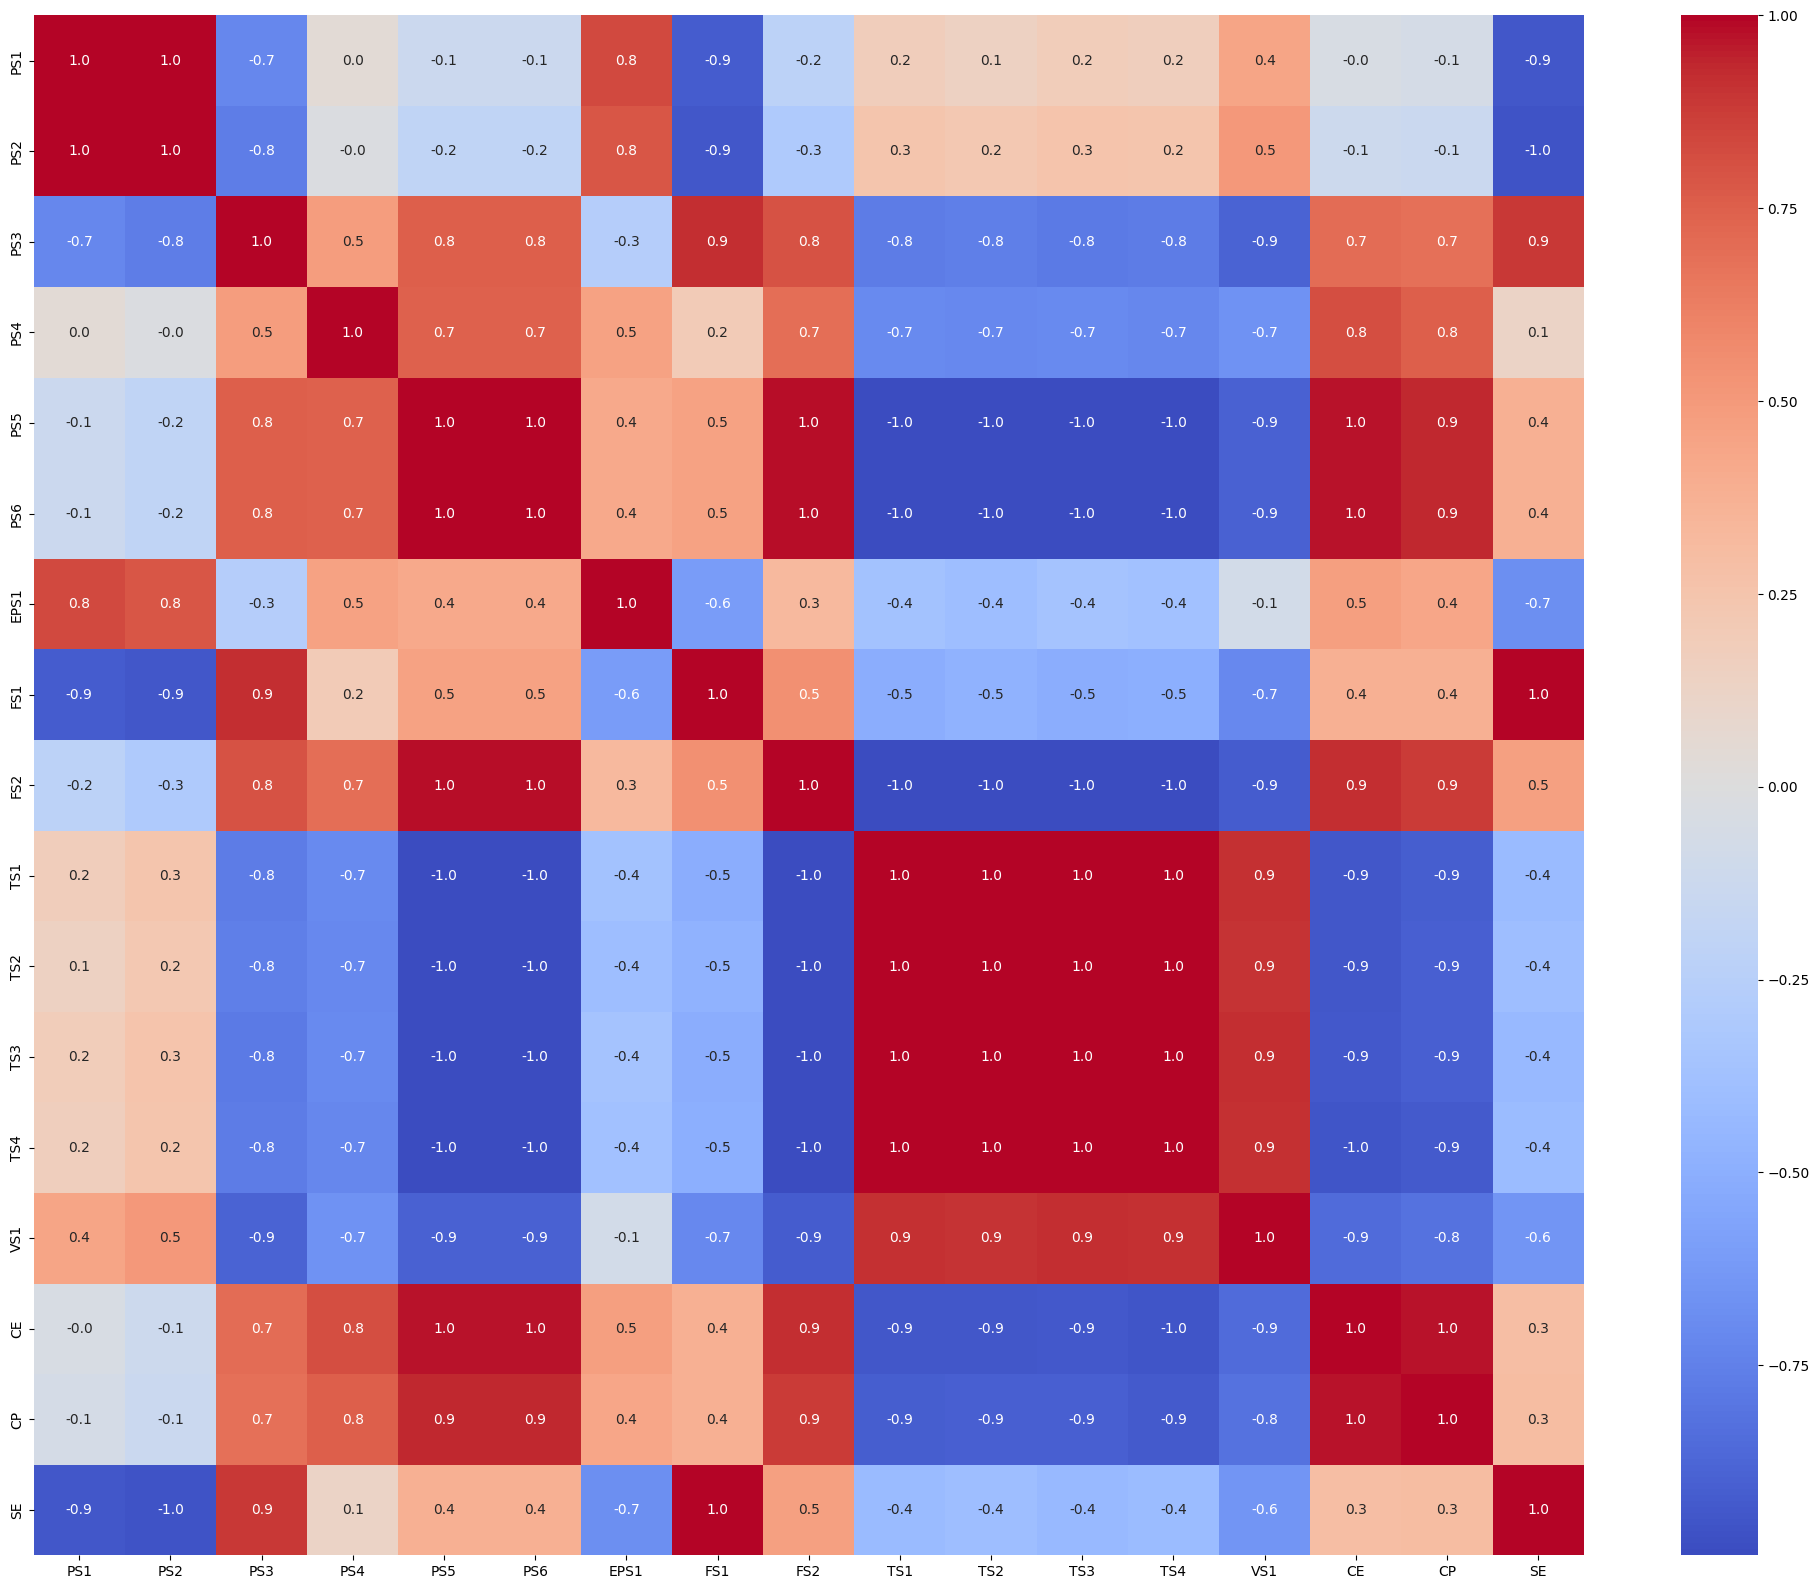

In [19]:
fig, ax = plt.subplots(figsize=(25, 20))  # Increase the height to allow more space for y-axis labels
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".1f", ax=ax)  # fmt=".2f" for two decimal places in annotations
plt.show()
#fig.savefig("Correlation Matrix.png")

#### Correlation Matrix between Dependent Variables

In [20]:
df_profile.corr()

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
Cooler_Condition,1.000000,0.004952,-0.004656,-0.203954,-0.004105
Valve_Condition,0.004952,1.000000,-0.352610,-0.082222,0.629433
Internal_Pump_Leakage,-0.004656,-0.352610,1.000000,0.077303,-0.549678
Hydraulic_Accumulator,-0.203954,-0.082222,0.077303,1.000000,-0.120817
Stable_Flag,-0.004105,0.629433,-0.549678,-0.120817,1.000000


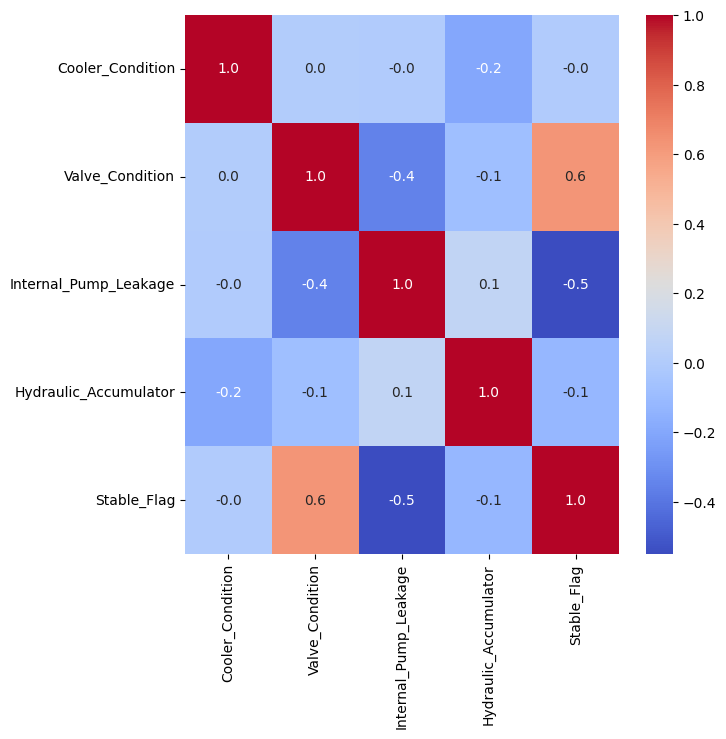

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))  # Increase the height to allow more space for y-axis labels
sns.heatmap(df_profile.corr(), annot=True, cmap="coolwarm", fmt=".1f", ax=ax)  # fmt=".2f" for two decimal places in annotations
plt.show()

#### Correlation Matrix between Dependent and Independent Variables

In [22]:
# Calculate the correlation matrix for df_final and sort the values
df_final_corr = df_final.corr().sort_values(["Cooler_Condition", "Valve_Condition", "Internal_Pump_Leakage", "Hydraulic_Accumulator", "Stable_Flag"], ascending=False)

# Extract a subset of the sorted correlation matrix containing only the specified target columns
df_final_corr_target = df_final_corr[["Cooler_Condition", "Valve_Condition", "Internal_Pump_Leakage", "Hydraulic_Accumulator", "Stable_Flag"]]

# Drop the rows corresponding to the same target columns from the extracted subset
df_final_corr_target.drop(["Cooler_Condition", "Valve_Condition", "Internal_Pump_Leakage", "Hydraulic_Accumulator", "Stable_Flag"], axis=0, inplace=True)

C:\Users\Ayat\AppData\Local\Temp\ipykernel_28232\3517443552.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_corr_target.drop(["Cooler_Condition", "Valve_Condition", "Internal_Pump_Leakage", "Hydraulic_Accumulator", "Stable_Flag"], axis=0, inplace=True)


In [23]:
df_final_corr_target

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
CE,0.991943,-0.001463,-0.000381,-0.204599,-0.015316
CP,0.956220,0.008605,-0.015806,-0.241432,-0.003231
PS6,0.950316,0.020284,-0.016262,-0.210282,0.021353
PS5,0.949962,0.020317,-0.016579,-0.209262,0.021458
FS2,0.881340,0.038651,-0.034926,-0.139471,0.055942
PS4,0.832446,-0.146385,0.154950,-0.001021,-0.244314
PS3,0.662852,0.163278,-0.355070,-0.006242,0.237027
EPS1,0.497514,-0.174618,0.426320,-0.239692,-0.267649
FS1,0.330446,0.190141,-0.421702,0.092695,0.288568
SE,0.249273,0.231354,-0.469243,0.112756,0.324695


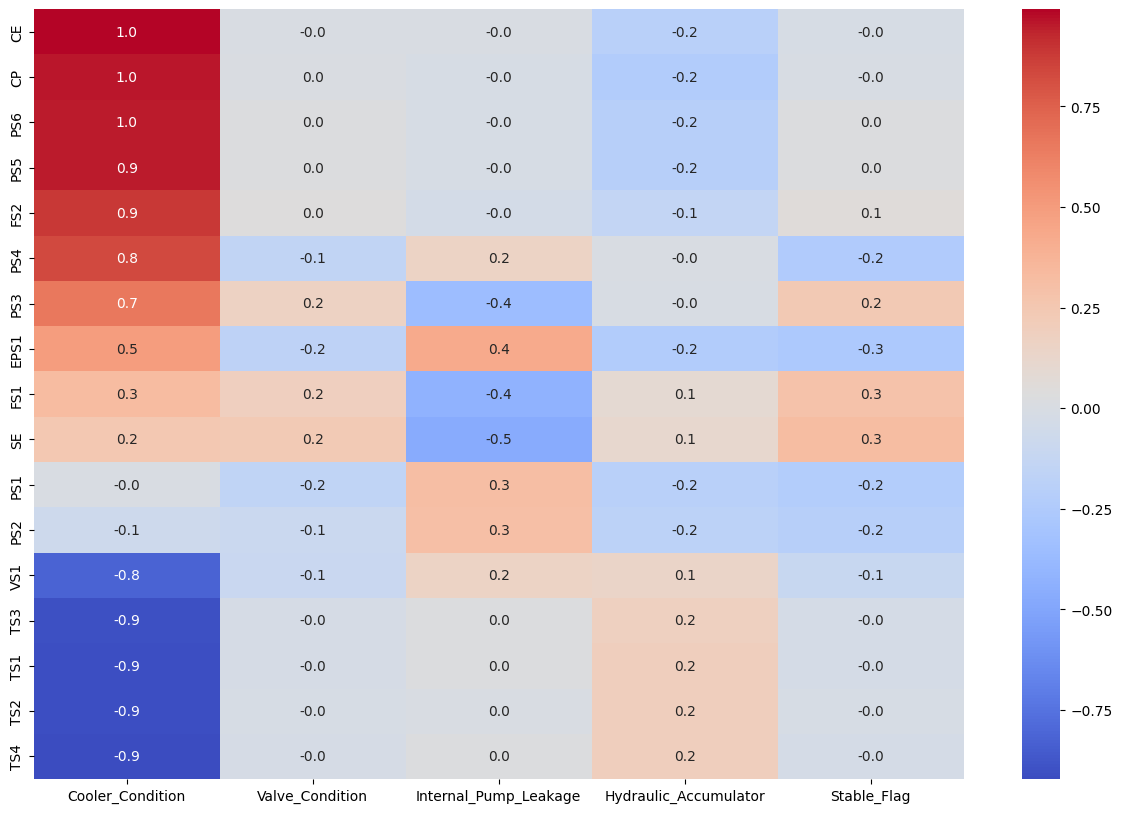

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))  # Increase the height to allow more space for y-axis labels
sns.heatmap(df_final_corr_target, annot=True, cmap="coolwarm", fmt=".1f", ax=ax)  # fmt=".2f" for two decimal places in annotations
plt.show()

# Feature Extraction

### Signal Shape 
-	Slope Of Linear Fit (SOLF): a parameter denotes the slope obtained from a singular measurement of the specific sensor during each operational cycle.
-	Maximum Value Position (MVP): a parameter that denotes the specific position of the maximum value recorded for each sensor in every operational cycle. It serves the purpose of ranking the maximum value of the respective sensor in comparison to all other maximum values acquired from various lines.


In [25]:
# Signal Shape 
# Function to extract feature slope of linear fit
def slope_of_linear_fit(x):
    n = len(x)
    X = np.arange(n)
    A = np.vstack([X, np.ones(n)]).T
    m, c = np.linalg.lstsq(A, x, rcond=None)[0]
    return m

# Function to extract maximum value position
def max_value_position(x):
    return np.argmax(x)

### Distribution Density Measures
-	Median (MED): This parameter signifies the value considered by the statistical units in the midpoin tof the distribution for each sensor and cycle.
-	Variance (VAR): For every sensor and cycle, this metric represents the extent of variability within the data. 
-	Skewness (SKEW): It indicates the symmetry index inherent in the data for each sensor and cycle.
-	Kurtosis (KURT): This parameter reflects, for every sensor and cycle, a deviation from the normal distribution, indicating either more significant flattening or more significant stretching of the distribution than a normal distribution.


In [26]:
# Function to extract distribution density measures
# Function to extract the median value
def median_value(x):
    return np.median(x)

# Function to extract the variance
def variance_value(x):
    return np.var(x)

def distribution_density_measures(x):
    skewness = skew(x)
    kurtosis_val = kurtosis(x)
    # Handle cases where skewness or kurtosis are NaN
    if np.isnan(skewness):
        skewness = 0
    if np.isnan(kurtosis_val):
        kurtosis_val = 0
    return skewness, kurtosis_val

In [27]:
# Define a function to extract all features for each sensor reading
def extract_features(sensor_data):
    features = []
    for i in range(sensor_data.shape[0]):
        row = sensor_data[i, :]
        solf = slope_of_linear_fit(row)
        mvp = max_value_position(row)
        skewness, kurtosis_val = distribution_density_measures(row) 
        median = median_value(row)
        variance = variance_value(row)
        features.append([solf, mvp, skewness, kurtosis_val, median, variance])
    return np.array(features)

# Dictionary to store the extracted features
extracted_features = {}

# Apply feature extraction to each sensor
for sensor_name, data in sensor_data.items():
    extracted_features[sensor_name] = extract_features(data)

# Assign the extracted features
ps1_features = extracted_features["ps1"]
ps2_features = extracted_features["ps2"]
ps3_features = extracted_features["ps3"]
ps4_features = extracted_features["ps4"]
ps5_features = extracted_features["ps5"]
ps6_features = extracted_features["ps6"]
eps1_features = extracted_features["eps1"]
fs1_features = extracted_features["fs1"]
fs2_features = extracted_features["fs2"]
ts1_features = extracted_features["ts1"]
ts2_features = extracted_features["ts2"]
ts3_features = extracted_features["ts3"]
ts4_features = extracted_features["ts4"]
vs1_features = extracted_features["vs1"]
ce_features = extracted_features["ce"]
cp_features = extracted_features["cp"]
se_features = extracted_features["se"]

In [28]:
# Combine all features into a single DataFrame
features_combined = np.hstack([
    ps1_features, ps2_features, ps3_features, ps4_features, ps5_features, ps6_features,
    eps1_features, fs1_features, fs2_features, ts1_features, ts2_features, ts3_features, ts4_features,
    vs1_features, ce_features, cp_features, se_features
])

In [29]:
feature_columns = []
for sensor in ["PS1", "PS2", "PS3", "PS4", "PS5", "PS6", "EPS1", "FS1", "FS2", "TS1", "TS2", "TS3", "TS4", "VS1", "CE", "CP", "SE"]:
    feature_columns.extend([
        f"{sensor}_SOLF", f"{sensor}_MVP", f"{sensor}_Skewness", f"{sensor}_Kurtosis",
        f"{sensor}_Median", f"{sensor}_Variance"
    ])

features_df = pd.DataFrame(features_combined, columns=feature_columns)

In [30]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Columns: 102 entries, PS1_SOLF to SE_Variance
dtypes: float64(102)
memory usage: 1.7 MB


In [31]:
# features_df is your DataFrame
data_names = features_df.columns.tolist()


In [32]:
df_final=pd.concat([features_df,df_profile],axis=1)

# Feature Scaling

A normalisation operator becomes necessary when the features exhibit considerable variations in their ranges. This procedure aims to mitigate the impact of the magnitude of individual features during the learning phase. Specifically, the min-max normalisation is employed, resulting in the normalised signal denoted as Xi, with Xmax and Xmin representing the maximum and minimum values within the signal Xi. The collective preprocessed data, comprising all samples and dimensions, is symbolised as XNorm.

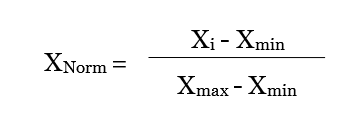

In [33]:
# Dictionary to store normalized data
normalized_data_dict = {}

scaler = MinMaxScaler()

# Loop through each sensor and normalize the data to [0, 1]
for sensor_name in data_names:
    sensor_data = df_final[sensor_name].values.reshape(-1, 1)
    
    # Normalize the data using MinMaxScaler
    normalized_data = scaler.fit_transform(sensor_data)
    normalized_data_dict[sensor_name] = normalized_data.flatten()

# Convert the dictionary to a DataFrame
scaling_df = pd.DataFrame(normalized_data_dict)

# To get a de-fragmented frame, make a copy of the DataFrame
scaling_df = scaling_df.copy()


In [34]:
scaling_df

,PS1_SOLF,PS1_MVP,PS1_Skewness,PS1_Kurtosis,PS1_Median,PS1_Variance,PS2_SOLF,PS2_MVP,PS2_Skewness,PS2_Kurtosis,...,CP_Skewness,CP_Kurtosis,CP_Median,CP_Variance,SE_SOLF,SE_MVP,SE_Skewness,SE_Kurtosis,SE_Median,SE_Variance
0,0.102128,0.065193,0.950061,0.765489,0.157813,0.001095,0.068305,0.191711,0.008556,0.987509,...,0.249104,0.020558,0.482836,0.661312,0.909428,0.75,0.014625,0.966423,0.975415,0.256516
1,0.089236,0.096133,0.951818,0.754285,0.152914,0.018110,0.064272,0.191711,0.007607,0.989601,...,0.429723,0.044587,0.094541,0.046780,0.919061,0.75,0.016764,0.962349,0.975777,0.264461
2,0.085990,0.064088,0.953113,0.755538,0.144146,0.025147,0.061998,0.191711,0.009142,0.987158,...,0.391898,0.069983,0.024479,0.004183,0.918124,0.75,0.015419,0.966117,0.981115,0.270017
3,0.084941,0.059669,0.954204,0.757598,0.140021,0.028522,0.061572,0.191711,0.009952,0.986345,...,0.325977,0.055148,0.000000,0.004734,0.915664,0.75,0.015108,0.966198,0.983692,0.278501
4,0.082338,0.134807,0.956060,0.761145,0.134348,0.033201,0.057077,0.191711,0.009235,0.988324,...,0.216120,0.118666,0.003658,0.003505,0.927732,0.75,0.022678,0.949563,0.983809,0.274175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.090483,0.040884,0.955903,0.755023,0.166581,0.005603,0.069448,0.191711,0.003045,0.995703,...,0.297799,0.066261,0.616488,0.002394,0.918019,0.75,0.007996,0.982010,0.974338,0.245686
2201,0.090448,0.045304,0.955447,0.753820,0.165549,0.006953,0.068868,0.192528,0.003438,0.996286,...,0.321017,0.107350,0.609173,0.004226,0.916535,0.75,0.007056,0.984239,0.973614,0.245942
2202,0.091263,0.044199,0.955576,0.754861,0.165807,0.005718,0.070035,0.191711,0.002714,0.995663,...,0.343445,0.048422,0.605796,0.005859,0.912435,0.75,0.004421,0.990688,0.972022,0.245523
2203,0.090214,0.048619,0.956108,0.755264,0.166323,0.005425,0.068703,0.191711,0.001942,0.998083,...,0.322657,0.125802,0.608891,0.002274,0.916533,0.75,0.007160,0.983968,0.972645,0.242789


# Feature Selection

In [35]:
# List of target variables
target_variables = ["Cooler_Condition", "Valve_Condition", "Internal_Pump_Leakage",
                    "Hydraulic_Accumulator", "Stable_Flag"]


#### Pearson correlation


The Pearson correlation coefficient serves as a valuable statistical tool for discerning the magnitude and direction of linear associations between variables. Represented by the symbol "r," this statistical measure quantifies the strength and direction of a linear relationship existing between two variables. The coefficient's numerical value ranges from -1 to +1, where +1 signifies a flawless positive linear relationship, -1 denotes a flawless negative linear relationship, and 0 implies the absence of a linear correlation. The calculation of the Pearson correlation coefficient follows a defined formula, expressed as:

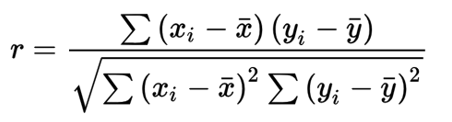

“xi” and “yi” represent individual features of the x-variable and y-variable, respectively, and “x bar” and “y bar” denote their respective means. This coefficient evaluates the features' strength and direction of a linear relationship. Understanding the hydraulic system parameters, their interactions, and the correlation between these features is essential for predictive maintenance and condition monitoring.

In [36]:
# Dictionary to store selected features for each target variable
selected_features_corr_dict_pearson = {}

# Loop through each target variable
for target_variable in target_variables:
    # Calculate Pearson correlation using scaling_df for both target and features
    correlation_target = scaling_df.corrwith(df_final[target_variable])
    
    # Select features based on correlation threshold (
    selected_features_corr = correlation_target[abs(correlation_target) > 0.1].index.tolist()
    
    # Store selected features in the dictionary
    selected_features_corr_dict_pearson[target_variable] = selected_features_corr

In [37]:
selected_features_corr_dict_pearson

{'Cooler_Condition': ['PS1_SOLF',
  'PS1_MVP',
  'PS1_Skewness',
  'PS1_Kurtosis',
  'PS1_Median',
  'PS1_Variance',
  'PS2_MVP',
  'PS2_Skewness',
  'PS2_Kurtosis',
  'PS2_Median',
  'PS2_Variance',
  'PS3_SOLF',
  'PS3_Skewness',
  'PS3_Kurtosis',
  'PS3_Median',
  'PS3_Variance',
  'PS4_MVP',
  'PS4_Skewness',
  'PS4_Median',
  'PS5_SOLF',
  'PS5_Skewness',
  'PS5_Kurtosis',
  'PS5_Median',
  'PS6_SOLF',
  'PS6_Skewness',
  'PS6_Kurtosis',
  'PS6_Median',
  'EPS1_SOLF',
  'EPS1_Skewness',
  'EPS1_Kurtosis',
  'EPS1_Variance',
  'FS1_SOLF',
  'FS1_MVP',
  'FS1_Skewness',
  'FS1_Median',
  'FS1_Variance',
  'FS2_SOLF',
  'FS2_MVP',
  'FS2_Skewness',
  'FS2_Kurtosis',
  'FS2_Median',
  'FS2_Variance',
  'TS1_SOLF',
  'TS1_Skewness',
  'TS1_Kurtosis',
  'TS1_Median',
  'TS1_Variance',
  'TS2_SOLF',
  'TS2_MVP',
  'TS2_Kurtosis',
  'TS2_Median',
  'TS2_Variance',
  'TS3_MVP',
  'TS3_Skewness',
  'TS3_Kurtosis',
  'TS3_Median',
  'TS4_Skewness',
  'TS4_Median',
  'VS1_SOLF',
  'VS1_MVP',


#### Linear Discriminant Analysis

LDA serves both dimensionality reduction and feature selection, pinpointing the most discriminative features. This enhances the efficiency of grouping data into classes by projecting it into a reduced feature space while preserving essential discriminant information. Implementing LDA enables the creation of a new feature dataset that captures key feature combinations, contributing to improved classification in our hydraulic system analysis.

In [38]:
# Dictionary to store selected features for each target variable
selected_features_lda_dict = {}

# Loop through each target variable
for target_variable in target_variables:
    X = df_final.drop(columns=[target_variable])
    y = df_final[target_variable]

    # Instantiate and fit the LDA model
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    
    # Get importance scores for each feature
    if len(lda.classes_) > 2:
        # Handle multiple classes by taking the mean of absolute coefficients across classes
        feature_importances = abs(lda.coef_).mean(axis=0)
    else:
        feature_importances = abs(lda.coef_[0])

    # Select features based on importance threshold 
    selected_features_lda = [feature for feature, importance in zip(data_names, feature_importances) if importance > 0.1]

    # Store selected features in the dictionary
    selected_features_lda_dict[target_variable] = selected_features_lda

# Models

### Initializing hyperparameters

In [39]:
# Initializing hyperparameters
random= 200
n_est= 300
ts_size = 0.2
# Deep Learning
epoch = 20
batchSize = 48 

### Function Definition for Plotting

In [40]:
#-------------------------------------------------------------------------------------------------------------------------------
# FUNCTION TO PLOT ROC FROM LSTM MODEL
#-------------------------------------------------------------------------------------------------------------------------------

def plot_roc_curvesLSTM(performance_metrics_dict):
    for target_variable, metrics in performance_metrics_dict.items():
        y_test = metrics['y_test']
        y_pred_prob = metrics['y_pred_prob']
        
        # Ensure y_test is a numpy array
        #y_test = np.array(y_test)
        n_classes = y_pred_prob.shape[1]

        if n_classes > 2:  # Multiclass classification
            # Ensure y_test is binarized for multiclass
            if y_test.ndim == 1 or y_test.shape[1] != n_classes:
                y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
            else:
                y_test_bin = y_test
            
            plt.figure(figsize=(10, 8))
            for i in range(n_classes):
                if len(np.unique(y_test_bin[:, i])) == 1:  # Check if there's only one class
                    #print(f"Class {i} in {target_variable} has only one class in y_test. Skipping.")
                    continue
                
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) - Multiclass for {target_variable}')
            plt.legend(loc="lower right")
            plt.show()

        else:  # Binary classification
            if len(np.unique(y_test)) == 1:  # Check if there's only one class
                print(f"Binary classification in {target_variable} has only one class in y_test. Skipping.")
                continue

            # Flatten y_test and get probabilities for the positive class
            y_test_flat =  y_test[:, 1]
            y_pred_prob_flat = y_pred_prob[:, 1]
            
            fpr, tpr, _ = roc_curve(y_test_flat, y_pred_prob_flat)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(10, 8))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) - Binary for {target_variable}')
            plt.legend(loc="lower right")
            plt.show()
            
#-------------------------------------------------------------------------------------------------------------------------------
# FUNCTION TO PLOT ROC FROM ALL MODEL 
#-------------------------------------------------------------------------------------------------------------------------------
def plot_roc_curves(performance_metrics_dict):
    for target_variable, metrics in performance_metrics_dict.items():
        y_test = metrics['y_test']
        y_pred_prob = metrics['y_pred_prob']
        
        # Ensure y_test is a numpy array
        y_test = np.array(y_test)
        n_classes = y_pred_prob.shape[1]

        if n_classes > 2:  # Multiclass classification
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            
            plt.figure(figsize=(10, 8))
            for i in range(n_classes):
                if len(np.unique(y_test_bin[:, i])) == 1:  # Check if there's only one class
                    print(f"Class {i} in {target_variable} has only one class in y_test. Skipping.")
                    continue
                
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.7f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) - Multiclass for {target_variable}')
            plt.legend(loc="lower right")
            plt.show()

        else:  # Binary classification
            if len(np.unique(y_test)) == 1:  # Check if there's only one class
                print(f"Binary classification in {target_variable} has only one class in y_test. Skipping.")
                continue
                
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(10, 8))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.7f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) - Binary for {target_variable}')
            plt.legend(loc="lower right")
            plt.show()

### Random Forest

In [41]:
def train_models(target_variables, selected_features_dict, scaling_df, df_final):
    # Dictionary to store Random Forest models for each target variable
    random_forest_models = {}

    # Dictionary to store performance metrics for each target variable
    performance_metrics_dict = {}

    # Loop through each target variable
    for target_variable in target_variables:
        # Prepare the data with selected features
        selected_features = selected_features_dict[target_variable]
        X_selected = scaling_df[selected_features]
        y = df_final[target_variable]
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=ts_size, random_state=random)
        
        # Initialize Random Forest model
        rf_model = RandomForestClassifier(n_estimators=n_est, random_state=random)
        
        # Fit the model
        rf_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = rf_model.predict(X_test)
        #print(y_pred)
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)

        precision = precision_score(y_test, y_pred, average='weighted')

        recall = recall_score(y_test, y_pred, average='weighted')

        f1 = f1_score(y_test, y_pred, average='weighted')
        y_pred_prob = rf_model.predict_proba(X_test)
#---------------------------------------------------------------------------------------------------------
# Compute ROC AUC       
        y_pred_prob = rf_model.predict_proba(X_test)
        n_classes = y_pred_prob.shape[1]
        #print(n_classes)
        
        if len(set(y)) > 2:  # Multiclass classification
            roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='micro')
        else:  # Binary classification
            rf_prob = y_pred_prob[:, 1]
            roc_auc = roc_auc_score(y_test, rf_prob)

#---------------------------------------------------------------------------------------------------------
            
        #Store the trained model and performance metrics in dictionaries
        random_forest_models[target_variable] = rf_model
        performance_metrics_dict[target_variable] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'y_test': y_test,
            'y_pred_prob': y_pred_prob,
        }
    return random_forest_models, performance_metrics_dict

In [42]:
# Train models using all features
print("Training models using all features:")
selected_features_all_dict = {target: data_names for target in target_variables}
random_forest_models_all, performance_metrics_dict_all = train_models(
    target_variables, selected_features_all_dict, scaling_df, df_final
)

# Train models using features selected by Pearson correlation
print("Training models using features selected by Pearson correlation:")
random_forest_models_pearson, performance_metrics_dict_pearson = train_models(
    target_variables, selected_features_corr_dict_pearson, scaling_df, df_final
)

# Train models using features selected by LDA
print("Training models using features selected by LDA:")
random_forest_models_lda, performance_metrics_dict_lda= train_models(
    target_variables, selected_features_lda_dict, scaling_df, df_final)

Training models using all features:
Training models using features selected by Pearson correlation:
Training models using features selected by LDA:


In [43]:
rf_performance_df = pd.DataFrame(performance_metrics_dict_all).T
pca_rf_performance_df = pd.DataFrame(performance_metrics_dict_pearson).T
lda_rf_performance_df = pd.DataFrame(performance_metrics_dict_lda).T


In [44]:
rf_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,191 3.0 1899 100.0 99 3.0 1979...,"[[1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, ..."
Valve_Condition,0.99093,0.991225,0.99093,0.990974,0.999961,191 100.0 1899 73.0 99 100.0 1979...,"[[0.0, 0.0, 0.006666666666666667, 0.9933333333..."
Internal_Pump_Leakage,0.99093,0.991061,0.99093,0.990964,0.999758,191 0.0 1899 0.0 99 0.0 1979 2....,"[[1.0, 0.0, 0.0], [0.9833333333333333, 0.01666..."
Hydraulic_Accumulator,0.99093,0.991041,0.99093,0.990957,0.999737,191 130.0 1899 115.0 99 130.0 1979...,"[[0.0, 0.0, 0.0, 1.0], [0.023333333333333334, ..."
Stable_Flag,0.981859,0.982082,0.981859,0.981764,0.997509,191 1.0 1899 0.0 99 1.0 1979 0....,"[[0.023333333333333334, 0.9766666666666667], [..."


In [45]:
pca_rf_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,191 3.0 1899 100.0 99 3.0 1979...,"[[1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.99666666..."
Valve_Condition,0.997732,0.997763,0.997732,0.997737,0.999985,191 100.0 1899 73.0 99 100.0 1979...,"[[0.0, 0.0, 0.0033333333333333335, 0.996666666..."
Internal_Pump_Leakage,0.988662,0.988897,0.988662,0.988717,0.99978,191 0.0 1899 0.0 99 0.0 1979 2....,"[[0.9966666666666667, 0.0033333333333333335, 0..."
Hydraulic_Accumulator,0.986395,0.986543,0.986395,0.986405,0.999674,191 130.0 1899 115.0 99 130.0 1979...,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.14, 0.82, 0.04]..."
Stable_Flag,0.979592,0.9797,0.979592,0.979503,0.996356,191 1.0 1899 0.0 99 1.0 1979 0....,"[[0.056666666666666664, 0.9433333333333334], [..."


In [46]:
lda_rf_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,191 3.0 1899 100.0 99 3.0 1979...,"[[1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, ..."
Valve_Condition,0.986395,0.986573,0.986395,0.986423,0.998882,191 100.0 1899 73.0 99 100.0 1979...,"[[0.0, 0.0, 0.0033333333333333335, 0.996666666..."
Internal_Pump_Leakage,0.99093,0.991061,0.99093,0.990964,0.999747,191 0.0 1899 0.0 99 0.0 1979 2....,"[[0.9966666666666667, 0.0033333333333333335, 0..."
Hydraulic_Accumulator,0.99093,0.991041,0.99093,0.990957,0.999793,191 130.0 1899 115.0 99 130.0 1979...,"[[0.0, 0.0, 0.0, 1.0], [0.02, 0.23666666666666..."
Stable_Flag,0.984127,0.984497,0.984127,0.984028,0.996875,191 1.0 1899 0.0 99 1.0 1979 0....,"[[0.02666666666666667, 0.9733333333333334], [1..."


### ROC Plot


#------------------------------------------------------------------------------------------------------------------------------
# All Features / Random Forest
#------------------------------------------------------------------------------------------------------------------------------


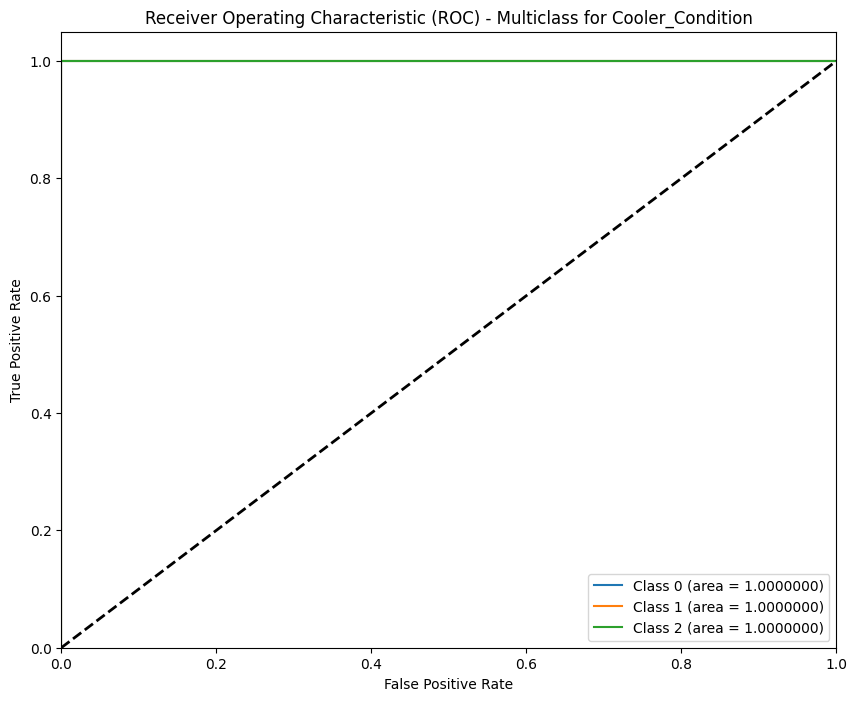

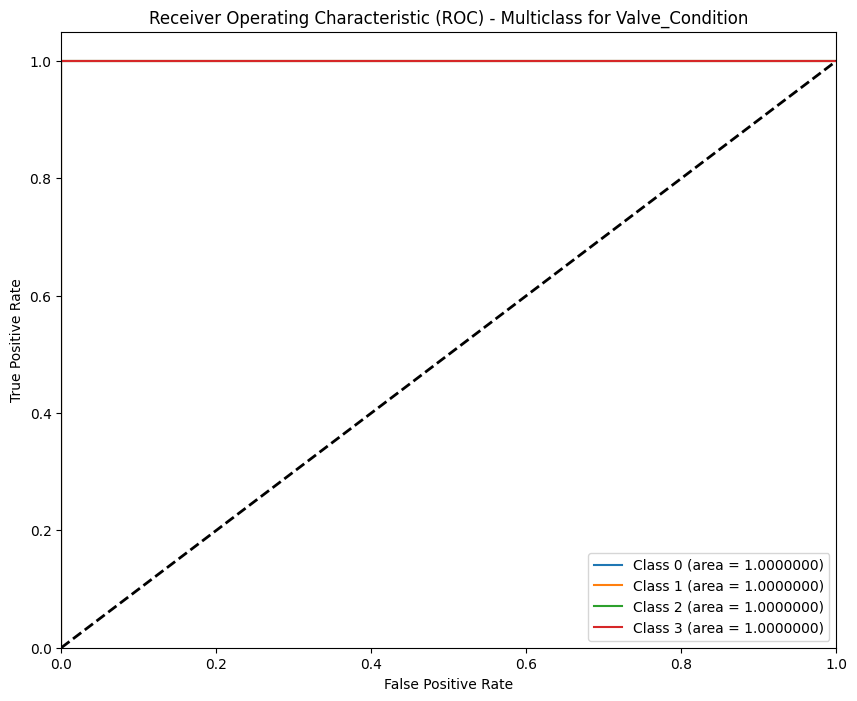

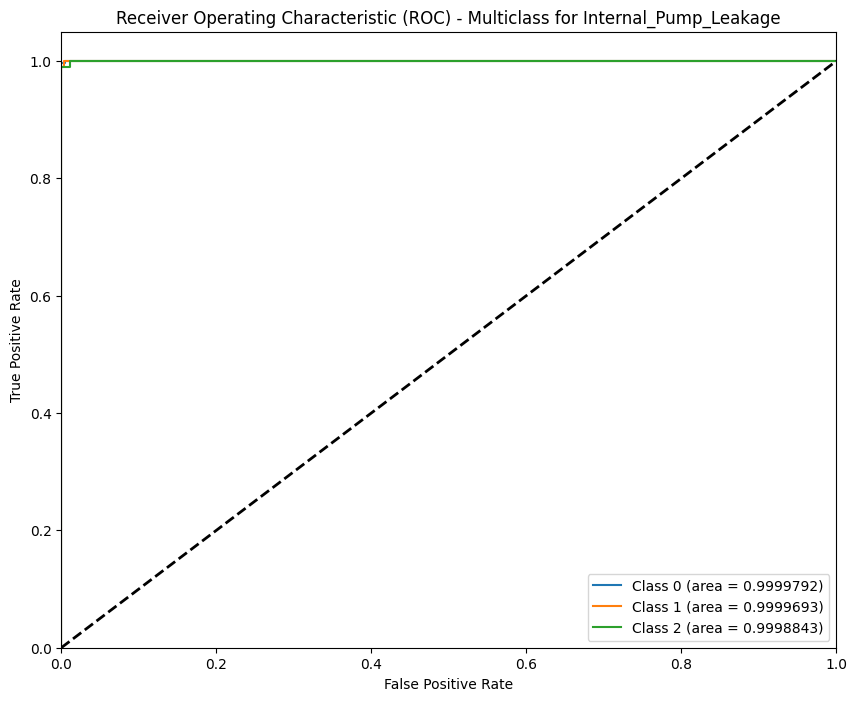

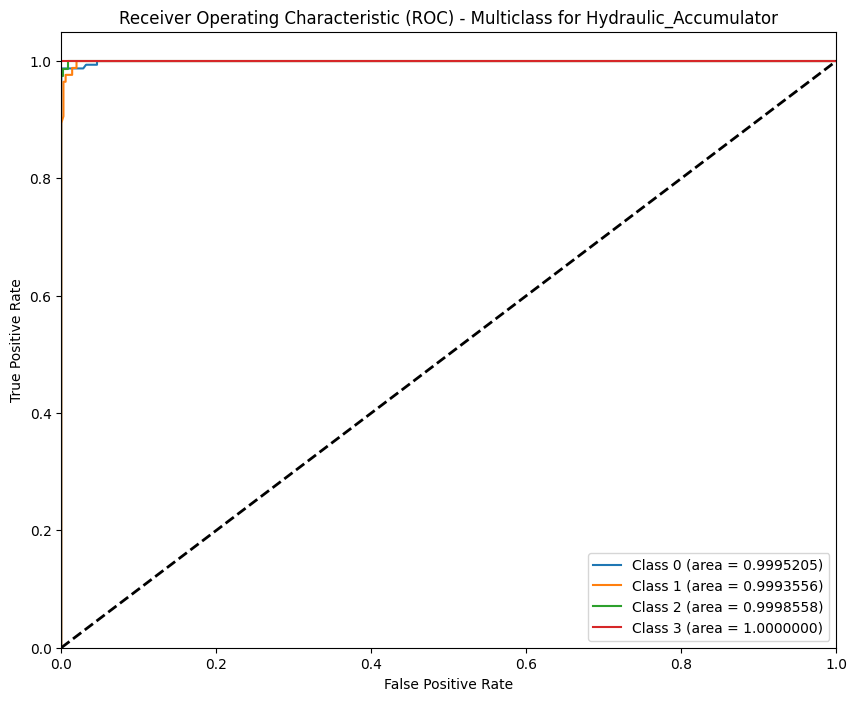

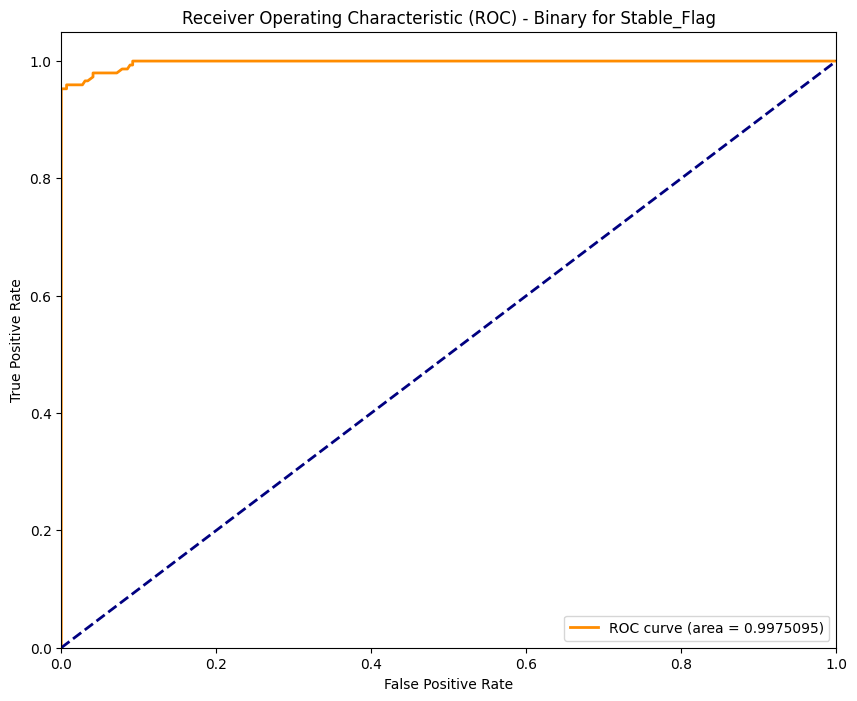


#------------------------------------------------------------------------------------------------------------------------------
# Features selected by Pearson / Random Forest
#------------------------------------------------------------------------------------------------------------------------------


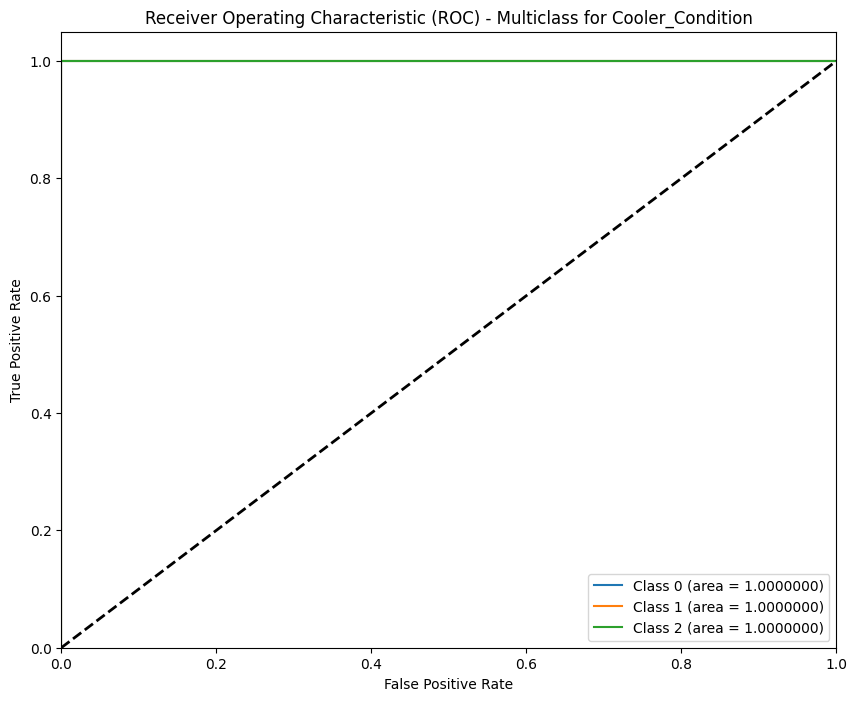

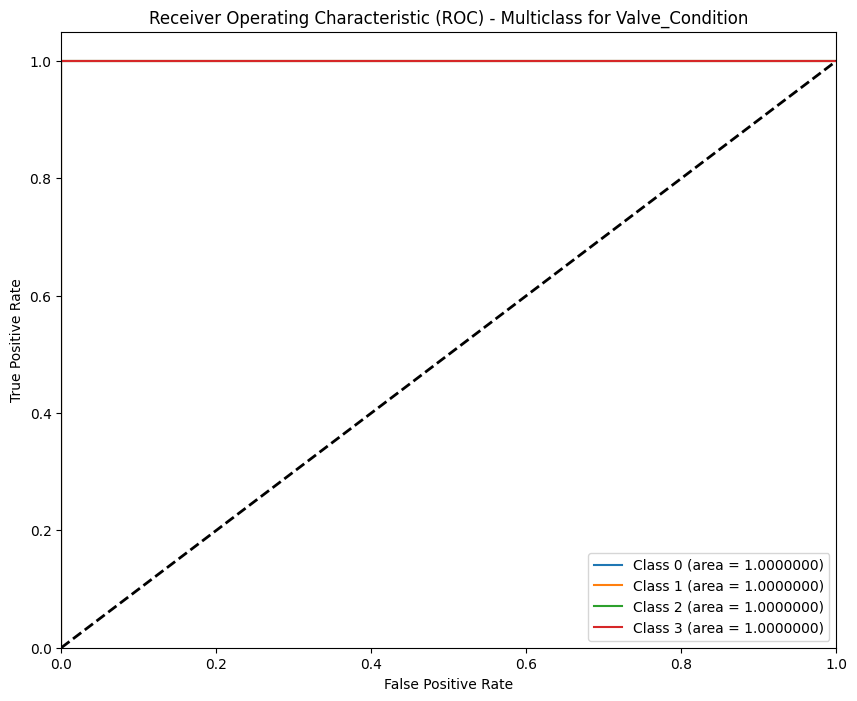

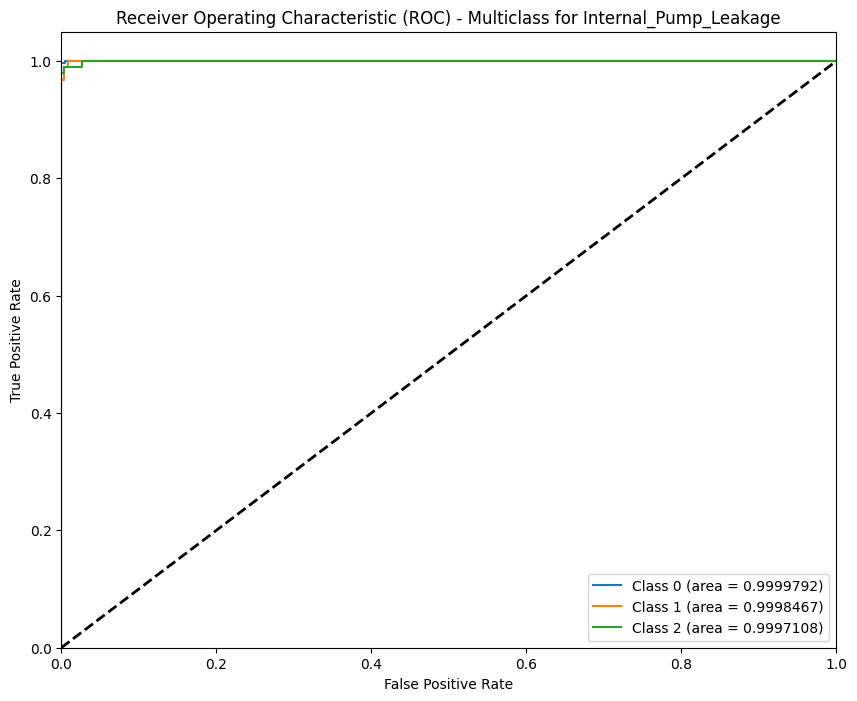

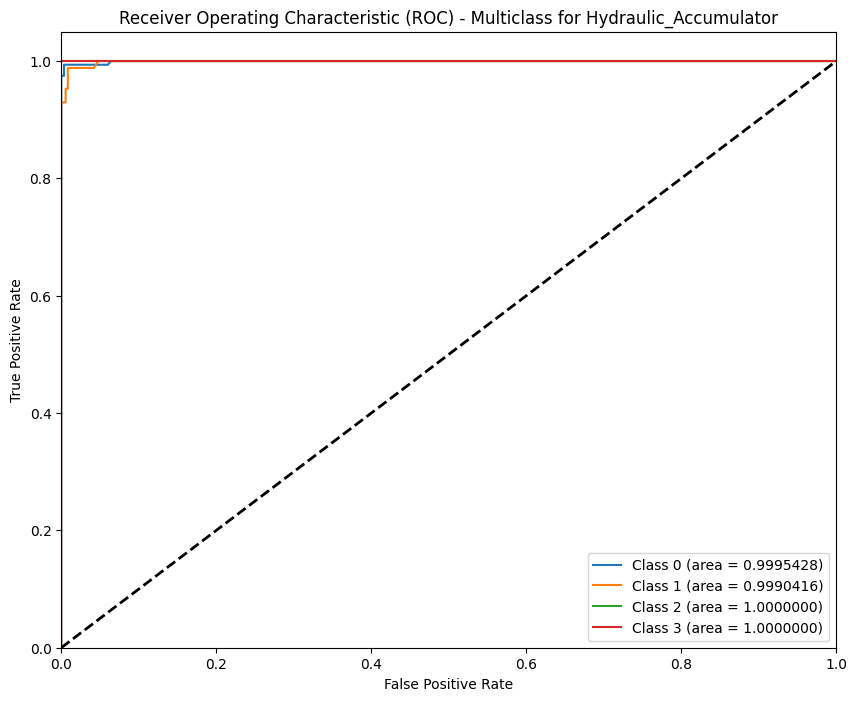

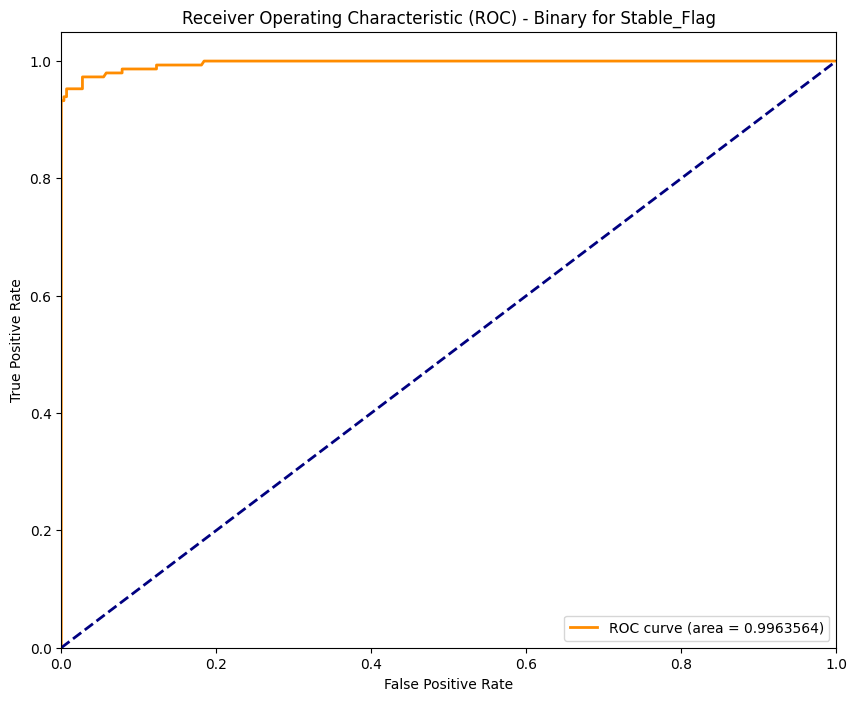


#------------------------------------------------------------------------------------------------------------------------------
# Features selected by LDA / Random Forest
#------------------------------------------------------------------------------------------------------------------------------


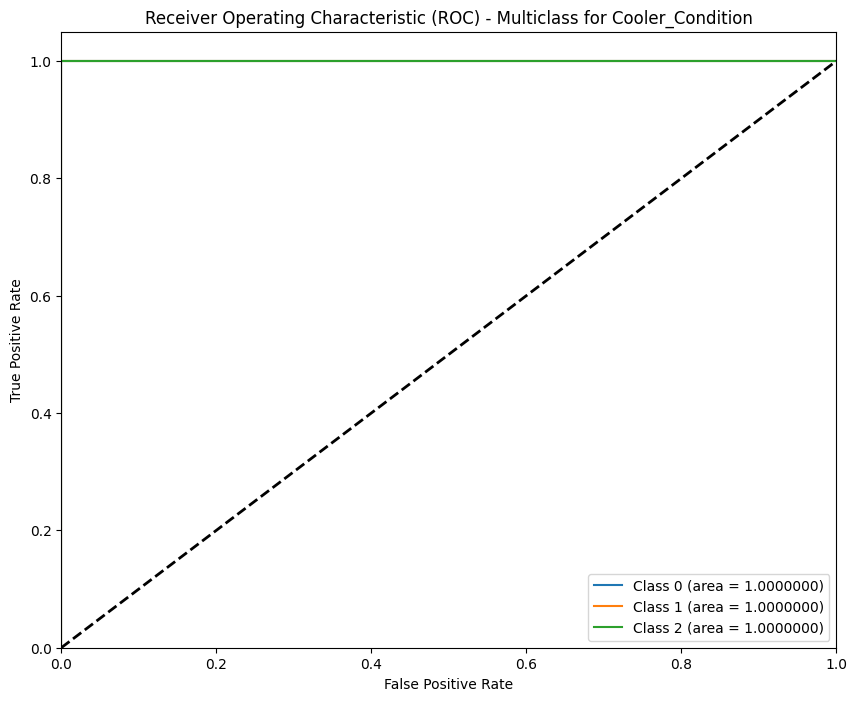

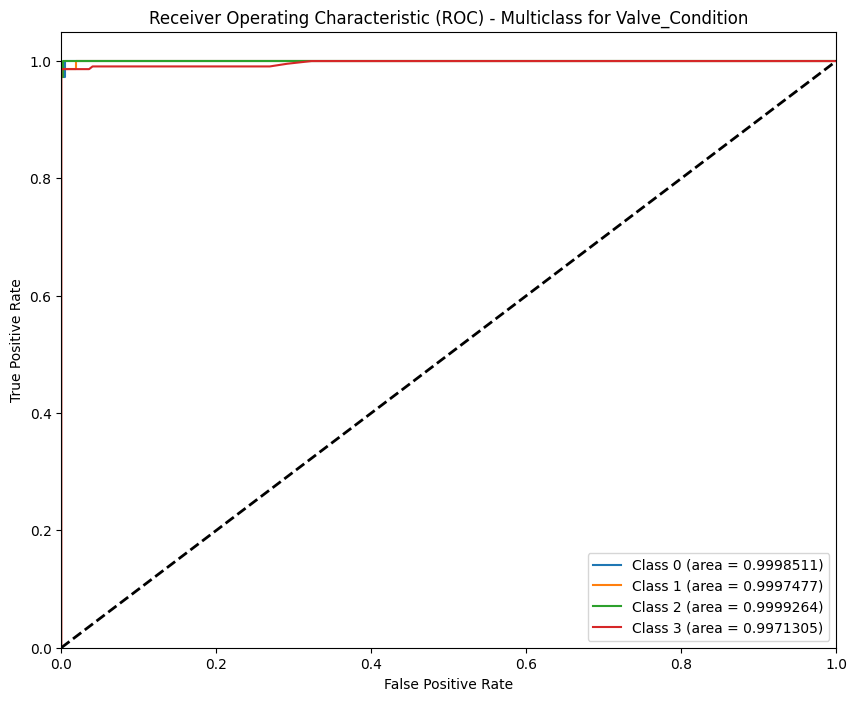

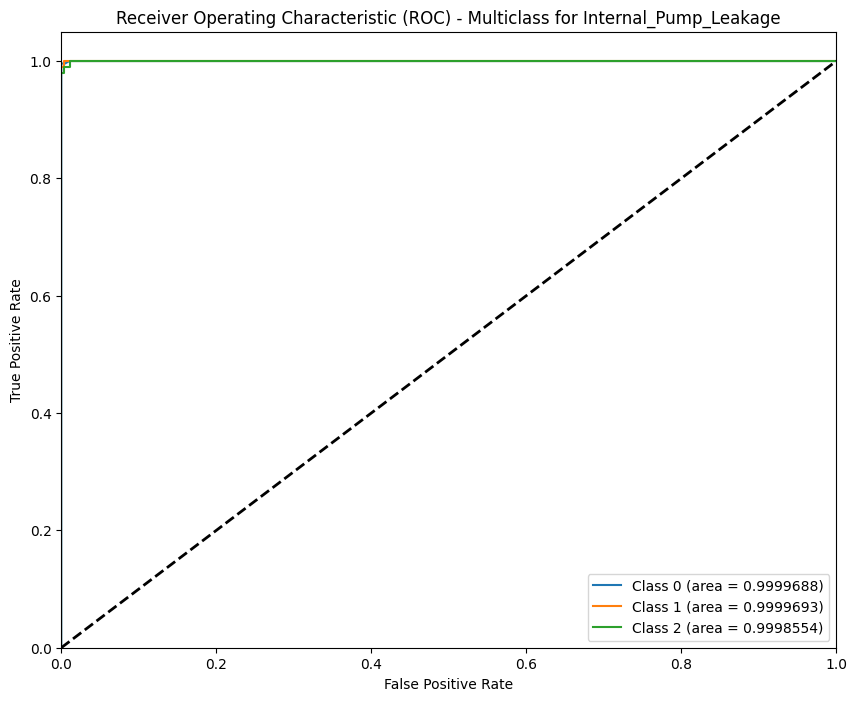

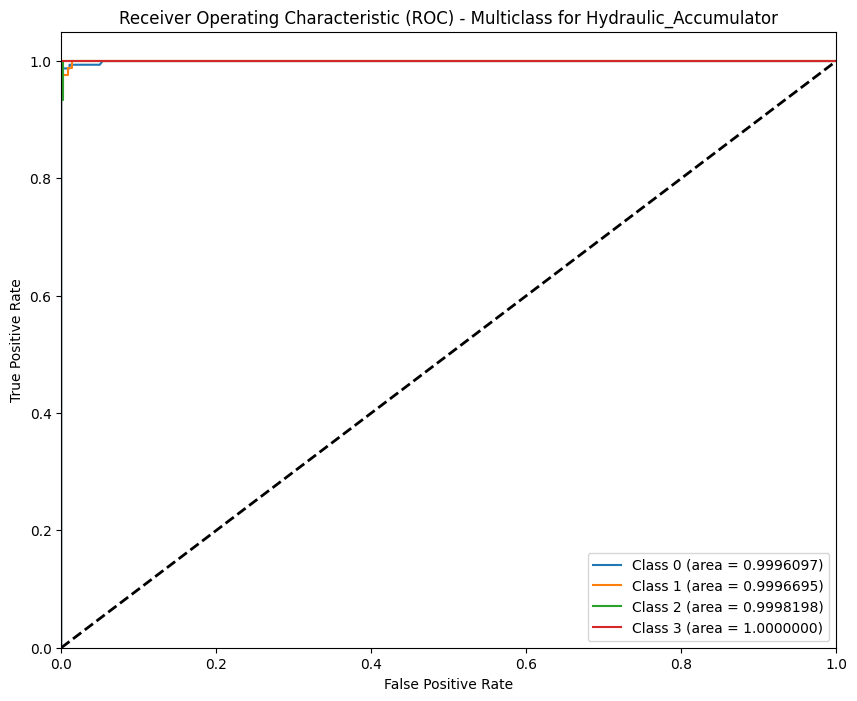

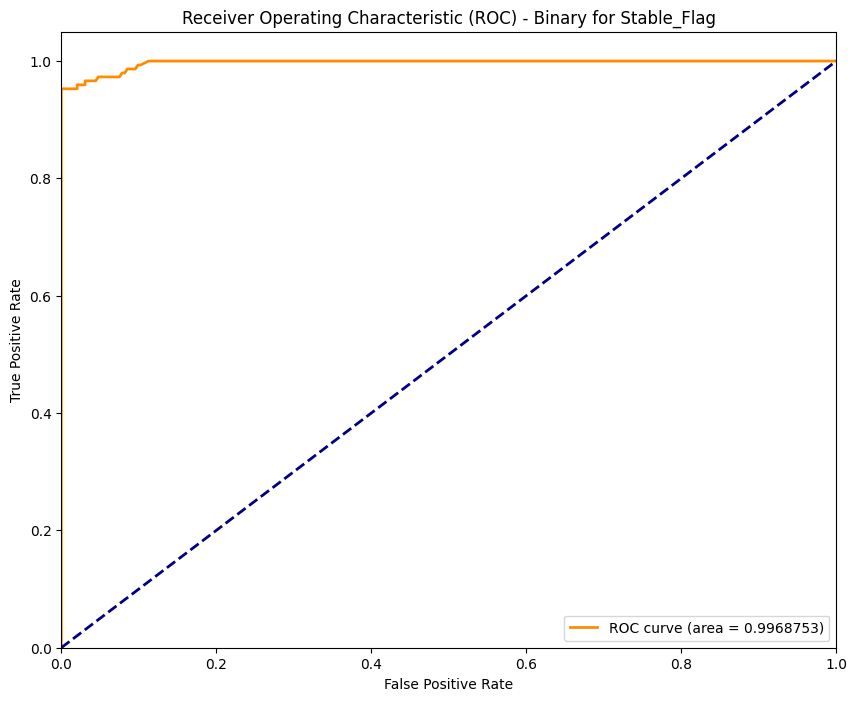

In [47]:
print('''
#------------------------------------------------------------------------------------------------------------------------------
# All Features / Random Forest
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curves(performance_metrics_dict_all)
print('''
#------------------------------------------------------------------------------------------------------------------------------
# Features selected by Pearson / Random Forest
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curves(performance_metrics_dict_pearson)
print('''
#------------------------------------------------------------------------------------------------------------------------------
# Features selected by LDA / Random Forest
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curves(performance_metrics_dict_lda)

### CatBoost

In [48]:
def cb_train_models(target_variables, selected_features_dict, scaling_df, df_final):
    # Dictionary to store CatBoost models for each target variable
    catboost_models = {}

    # Dictionary to store performance metrics for each target variable
    performance_metrics_dict = {}

    # Loop through each target variable
    for target_variable in target_variables:
        # Prepare the data with selected features
        selected_features = selected_features_dict[target_variable]
        X_selected = scaling_df[selected_features]
        y = df_final[target_variable]
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=ts_size, random_state=random)
        
        # Initialize CatBoost model
        catboost_model = CatBoostClassifier(iterations=n_est, random_seed=random, silent=True)
        
        # Fit the model
        catboost_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = catboost_model.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
#---------------------------------------------------------------------------------------------------------
# Compute ROC AUC
        y_pred_prob = catboost_model.predict_proba(X_test)
    
        if len(set(y)) > 2:  # Multiclass classification
            roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='micro')
        else:  # Binary classification
            y_prob = y_pred_prob[:, 1]
            roc_auc = roc_auc_score(y_test, y_prob)

#---------------------------------------------------------------------------------------------------------
        
        # Store the trained model and performance metrics in dictionaries
        catboost_models[target_variable] = catboost_model
        performance_metrics_dict[target_variable] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'y_test': y_test,
            'y_pred_prob': y_pred_prob,
        }
    return catboost_models, performance_metrics_dict

In [49]:
# Train models using all features
print("Training models using all features:")
selected_features_all_dict = {target: scaling_df.columns.tolist() for target in target_variables}
catboost_models_all, performance_metrics_dict_all = cb_train_models(
    target_variables, selected_features_all_dict, scaling_df, df_final
)

# Train models using features selected by Pearson correlation
print("Training models using features selected by Pearson correlation:")
catboost_models_pearson, performance_metrics_dict_pearson = cb_train_models(
    target_variables, selected_features_corr_dict_pearson, scaling_df, df_final
)

# Train models using features selected by LDA
print("Training models using features selected by LDA:")
catboost_models_lda, performance_metrics_dict_lda = cb_train_models(
    target_variables, selected_features_lda_dict, scaling_df, df_final
)

Training models using all features:
Training models using features selected by Pearson correlation:
Training models using features selected by LDA:


In [50]:
all_performance_df = pd.DataFrame(performance_metrics_dict_all).T
pearson_performance_df = pd.DataFrame(performance_metrics_dict_pearson).T
lda_performance_df = pd.DataFrame(performance_metrics_dict_lda).T


In [51]:
all_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,191 3.0 1899 100.0 99 3.0 1979...,"[[0.9998666515592955, 0.0001020023878190791, 3..."
Valve_Condition,1.0,1.0,1.0,1.0,1.0,191 100.0 1899 73.0 99 100.0 1979...,"[[2.3108902128528305e-05, 3.178393001503065e-0..."
Internal_Pump_Leakage,0.988662,0.988943,0.988662,0.98873,0.999743,191 0.0 1899 0.0 99 0.0 1979 2....,"[[0.9998216744405153, 0.00012026433811852992, ..."
Hydraulic_Accumulator,0.986395,0.986501,0.986395,0.986409,0.999594,191 130.0 1899 115.0 99 130.0 1979...,"[[0.000544385802410557, 0.00018111526813138645..."
Stable_Flag,0.988662,0.988852,0.988662,0.988613,0.998017,191 1.0 1899 0.0 99 1.0 1979 0....,"[[0.004853480715867775, 0.9951465192841322], [..."


In [52]:
pearson_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,191 3.0 1899 100.0 99 3.0 1979...,"[[0.9999331067735882, 4.987990342533334e-05, 1..."
Valve_Condition,1.0,1.0,1.0,1.0,1.0,191 100.0 1899 73.0 99 100.0 1979...,"[[2.8426595757050072e-05, 2.6336827431390657e-..."
Internal_Pump_Leakage,0.99093,0.990974,0.99093,0.990944,0.999835,191 0.0 1899 0.0 99 0.0 1979 2....,"[[0.9997471010397448, 0.00017273357739434206, ..."
Hydraulic_Accumulator,0.977324,0.977642,0.977324,0.977311,0.999453,191 130.0 1899 115.0 99 130.0 1979...,"[[0.00033886484073418076, 9.99016628631258e-05..."
Stable_Flag,0.984127,0.984112,0.984127,0.984114,0.998317,191 1.0 1899 0.0 99 1.0 1979 0....,"[[0.005897961291157494, 0.9941020387088425], [..."


In [53]:
lda_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,191 3.0 1899 100.0 99 3.0 1979...,"[[0.9998861087510391, 8.464655570478913e-05, 2..."
Valve_Condition,0.99093,0.99117,0.99093,0.99096,0.999762,191 100.0 1899 73.0 99 100.0 1979...,"[[0.0002754035341579248, 0.0001773035259764217..."
Internal_Pump_Leakage,0.988662,0.988778,0.988662,0.988699,0.99983,191 0.0 1899 0.0 99 0.0 1979 2....,"[[0.999799837454906, 0.00014210249580284446, 5..."
Hydraulic_Accumulator,0.988662,0.98898,0.988662,0.988743,0.999541,191 130.0 1899 115.0 99 130.0 1979...,"[[0.00017571367902588224, 6.565613130617311e-0..."
Stable_Flag,0.977324,0.977349,0.977324,0.977246,0.99631,191 1.0 1899 0.0 99 1.0 1979 0....,"[[0.012449466543889232, 0.9875505334561108], [..."


### ROC Plot


#------------------------------------------------------------------------------------------------------------------------------
# All Features / Catboost
#------------------------------------------------------------------------------------------------------------------------------


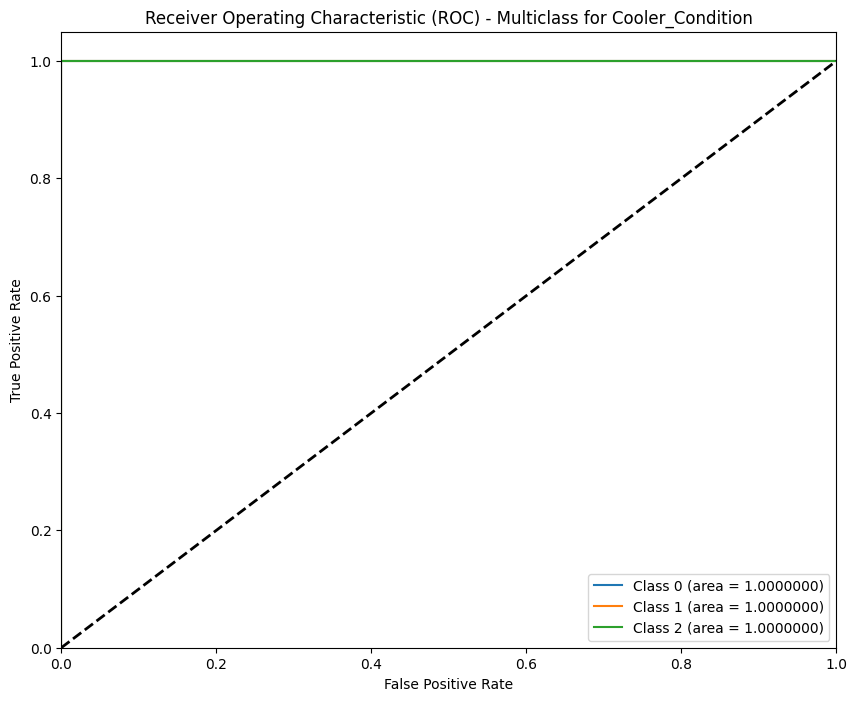

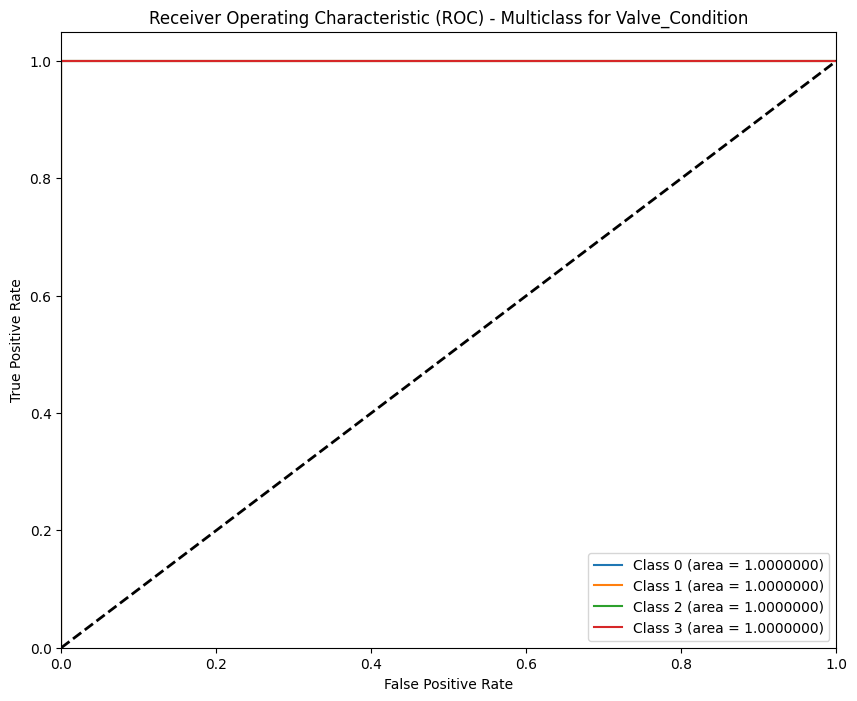

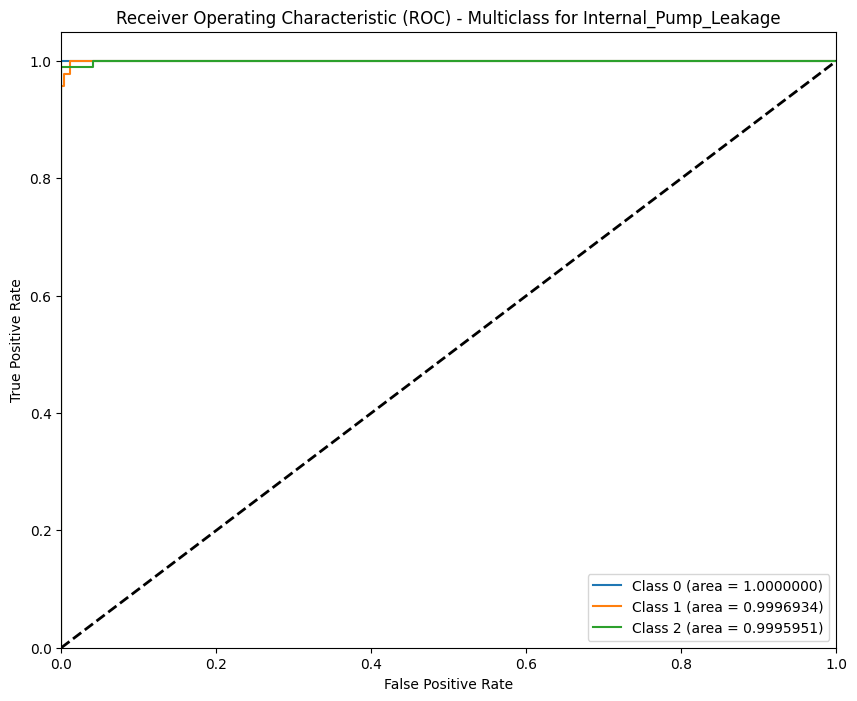

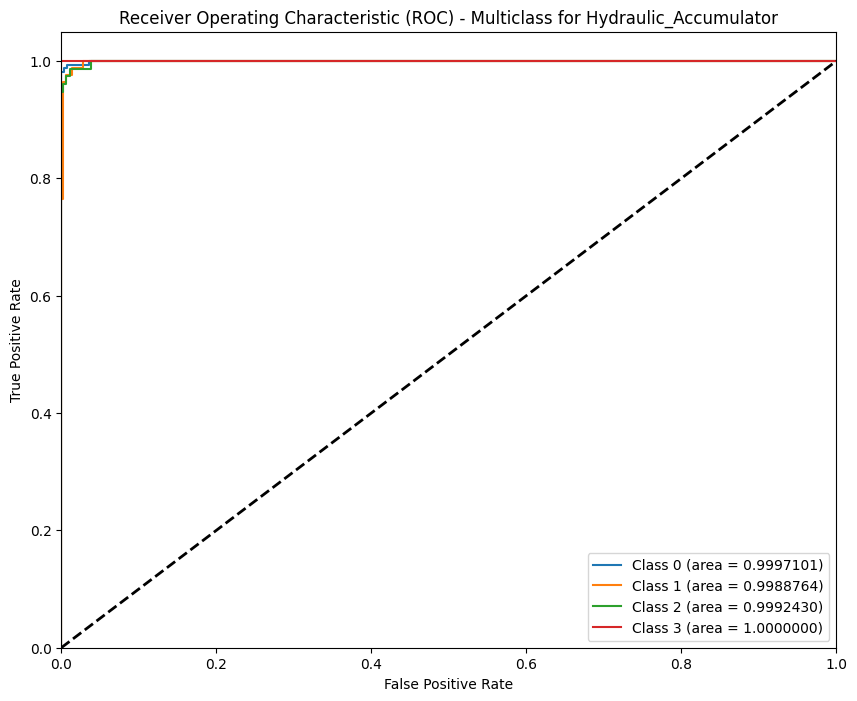

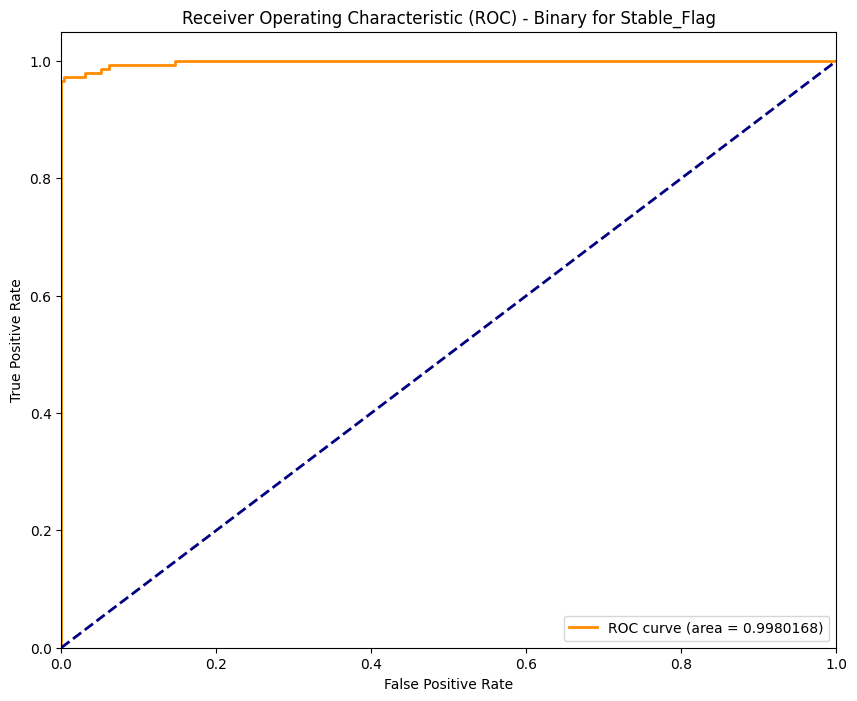


#------------------------------------------------------------------------------------------------------------------------------
# Features selected by Pearson / Catboost
#------------------------------------------------------------------------------------------------------------------------------


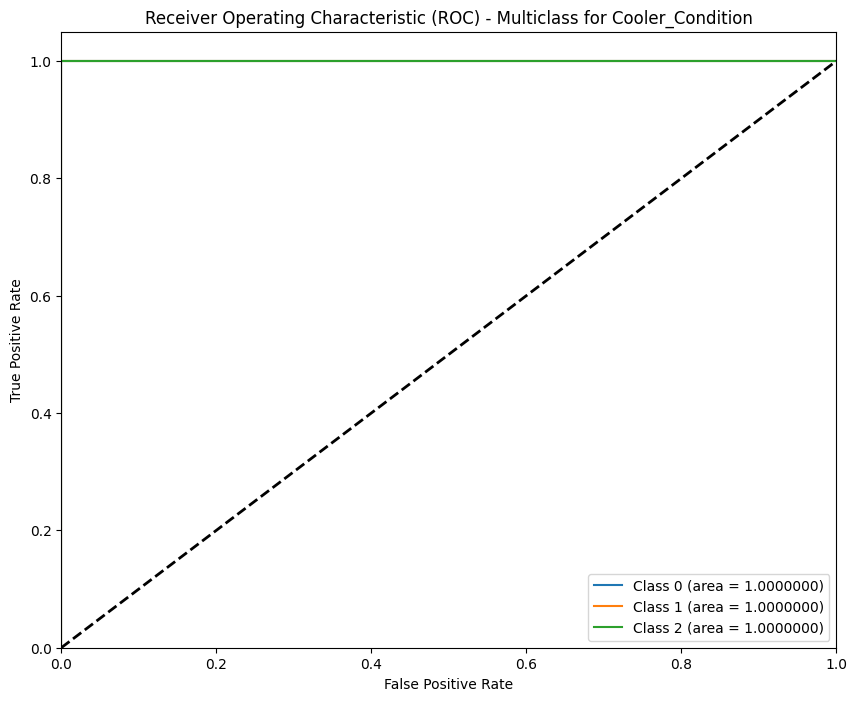

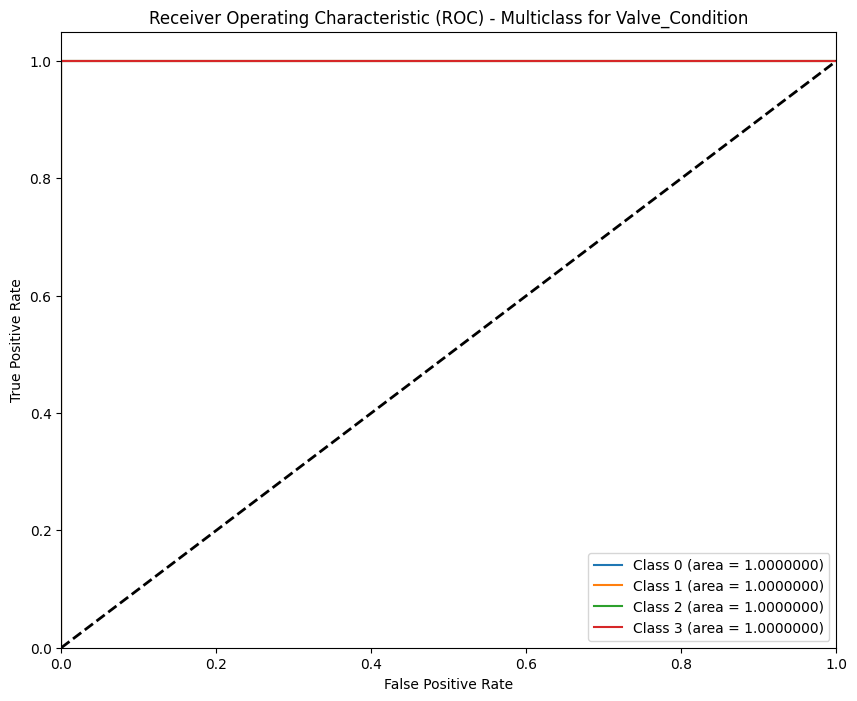

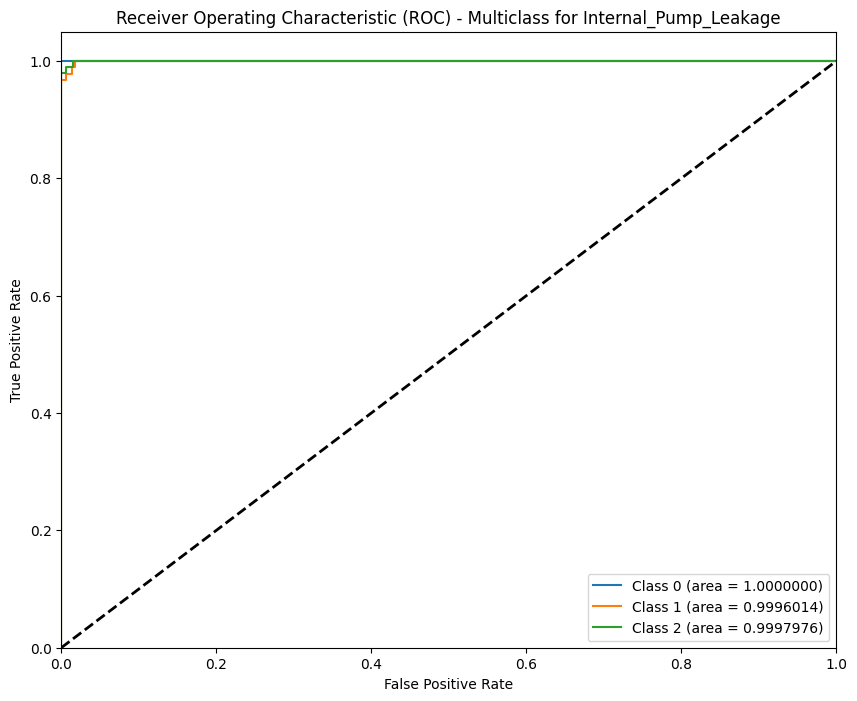

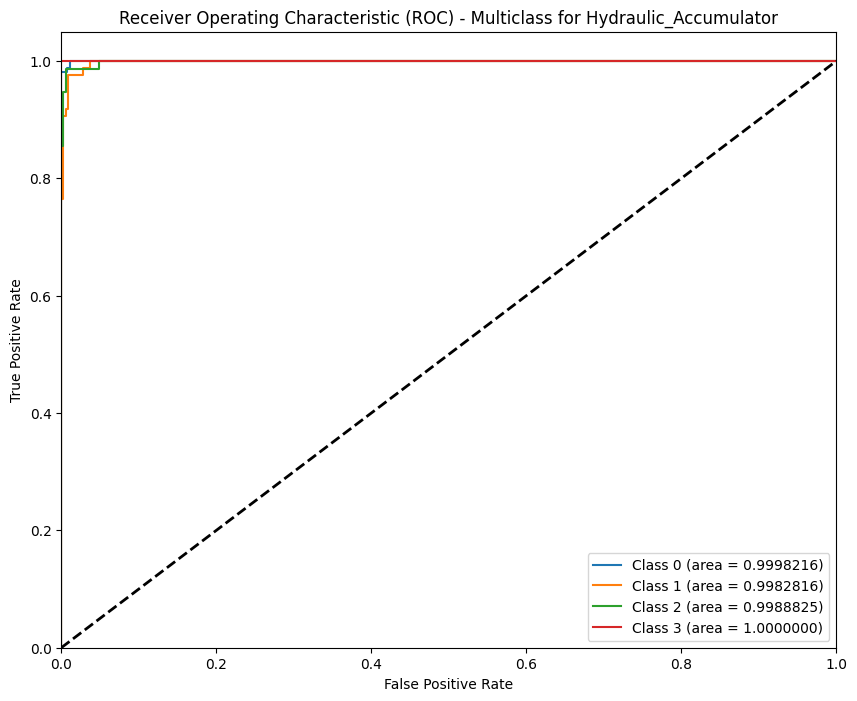

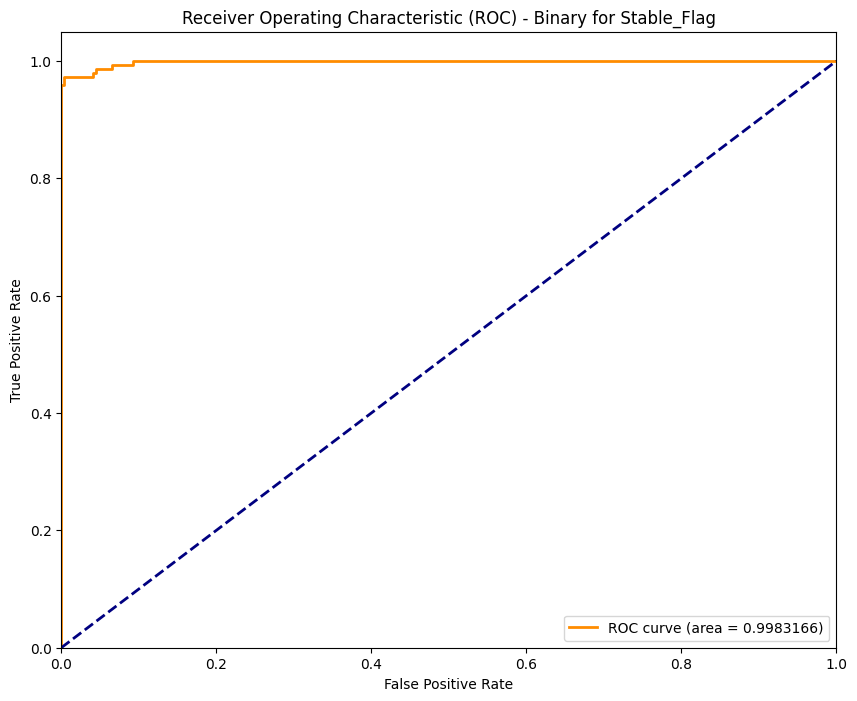


#------------------------------------------------------------------------------------------------------------------------------
# Features selected by LDA / Catboost
#------------------------------------------------------------------------------------------------------------------------------


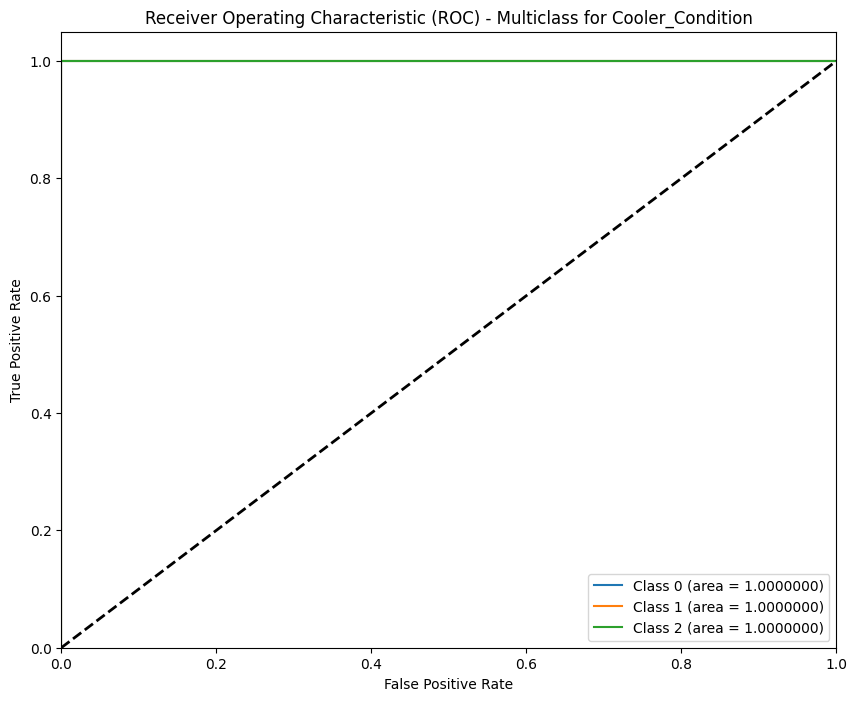

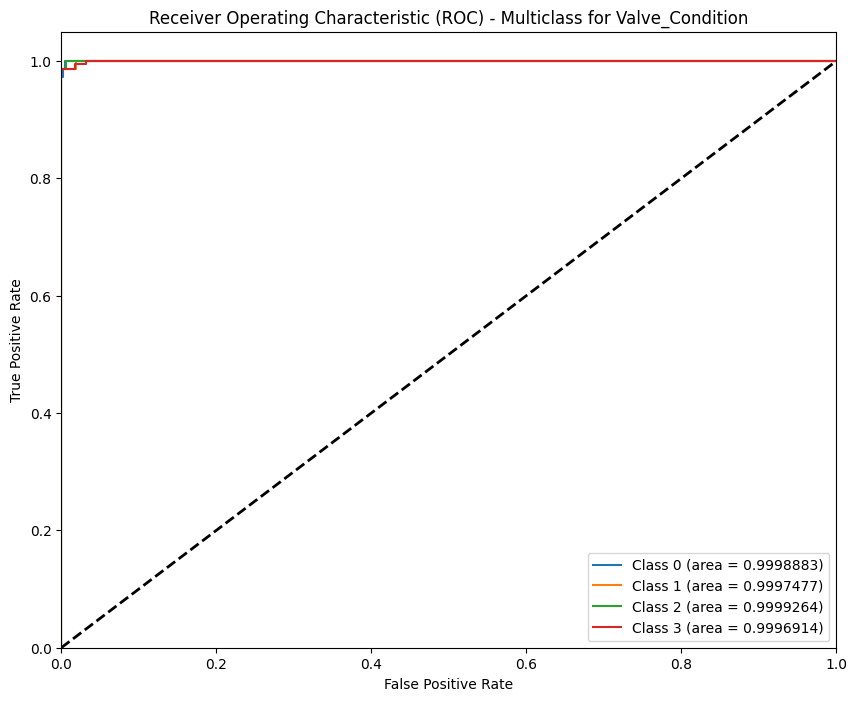

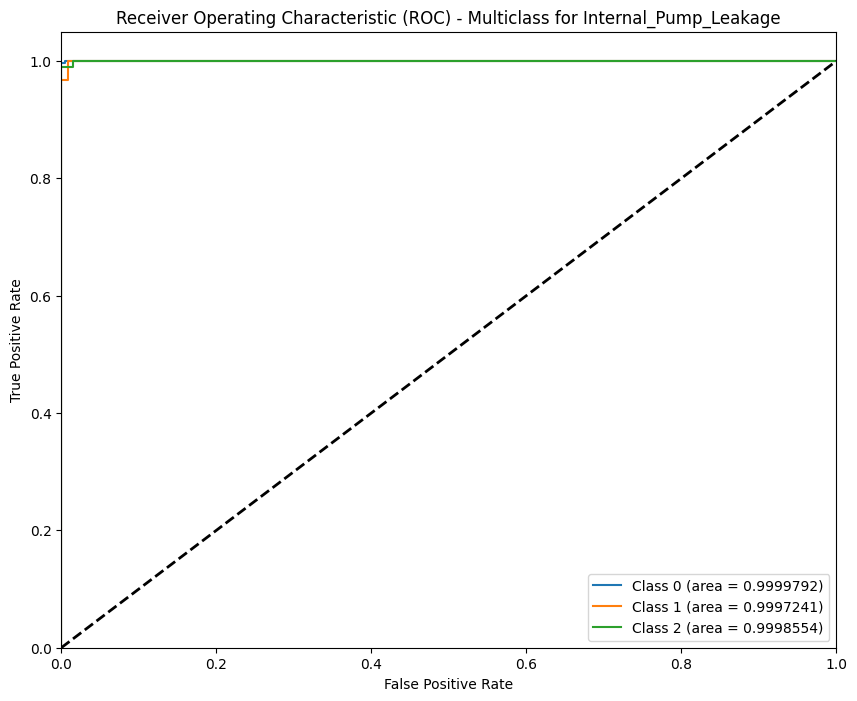

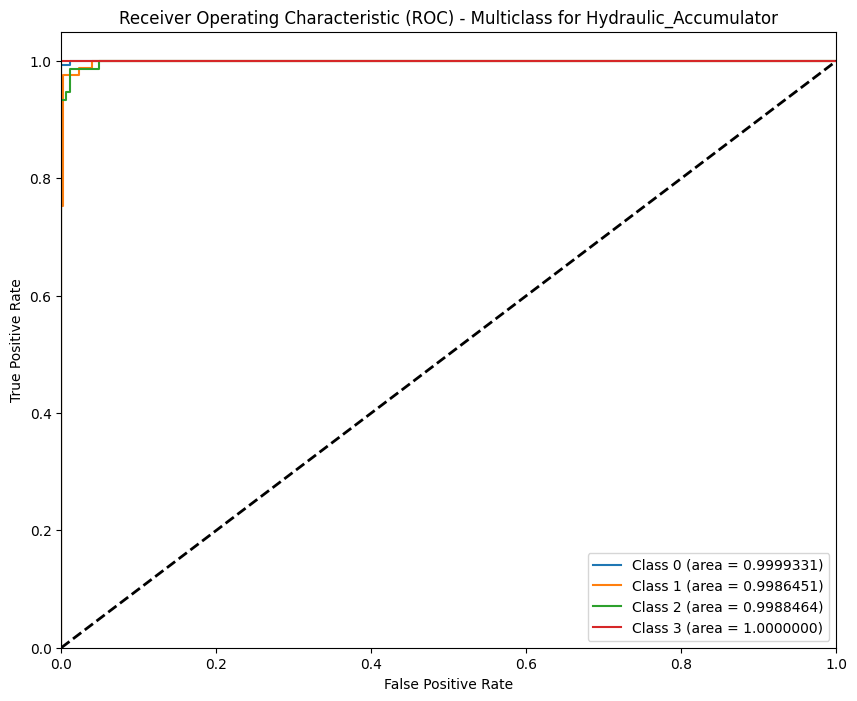

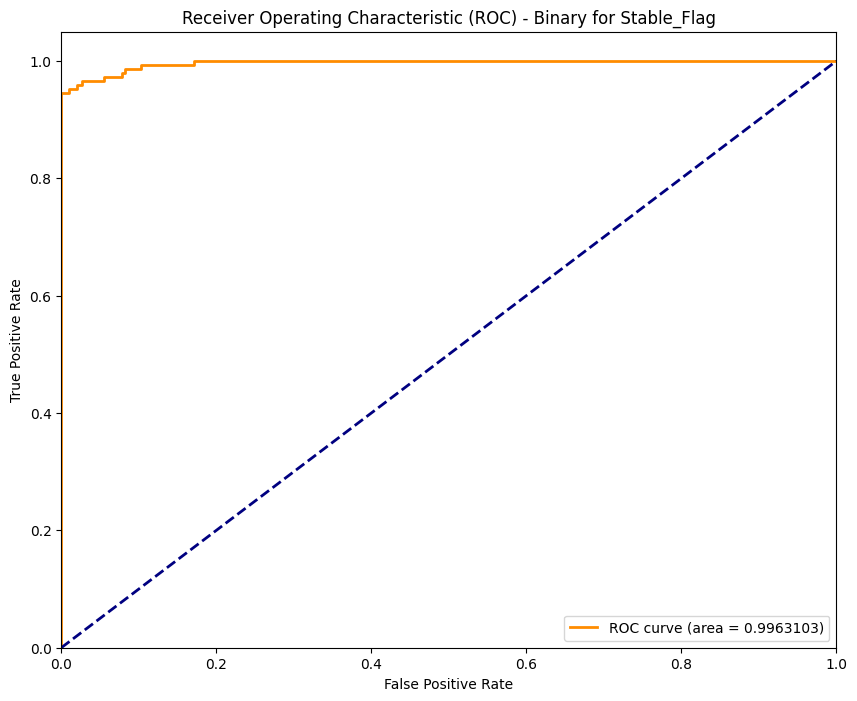

In [54]:
print('''
#------------------------------------------------------------------------------------------------------------------------------
# All Features / Catboost
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curves(performance_metrics_dict_all)
print('''
#------------------------------------------------------------------------------------------------------------------------------
# Features selected by Pearson / Catboost
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curves(performance_metrics_dict_pearson)
print('''
#------------------------------------------------------------------------------------------------------------------------------
# Features selected by LDA / Catboost
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curves(performance_metrics_dict_lda)

### LSTM

In [55]:
def lstm_model(input_shape, output_units):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(output_units, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=[AUC(name='auc')])
    return model

In [56]:
def lstm_train_models(target_variables, selected_features_dict, scaling_df, df_final):
    # Dictionary to store LSTM models for each target variable
    lstm_models = {}

    # Dictionary to store performance metrics for each target variable
    performance_metrics_dict = {}

    # Loop through each target variable
    for target_variable in target_variables:
        # Prepare the data with selected features
        selected_features = selected_features_dict[target_variable]
        X_selected = scaling_df[selected_features]
        y = df_final[target_variable]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=ts_size, random_state=random)
        
        # Scale the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Reshape the data to 3D for LSTM [samples, time steps, features]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # Convert the target variable to categorical
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        
        # Create LSTM model
        model = lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
        
        # Train the model
        model.fit(X_train, y_train, epochs=epoch, batch_size=batchSize, verbose=1)
        
        # Make predictions
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division= 0)
        recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division= 0)
        f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division= 0)
        
#---------------------------------------------------------------------------------------------------------
#CALCULATE ROC AUC
        y_prob = model.predict(X_test) 
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average='micro') 
#---------------------------------------------------------------------------------------------------------
        
        
        # Store the trained model and performance metrics in dictionaries
        lstm_models[target_variable] = model
        performance_metrics_dict[target_variable] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'y_test': y_test,
            'y_pred_prob': y_prob,
        }
    
    return lstm_models, performance_metrics_dict

### Training Models

In [57]:
# Train models using all features
print("Training models using all features:")
selected_features_all_dict = {target: scaling_df.columns.tolist() for target in target_variables}
lstm_models_all, performance_metrics_dict_all = lstm_train_models(
    target_variables, selected_features_all_dict, scaling_df, df_final
)

# Train models using features selected by Pearson correlation
print("Training models using features selected by Pearson correlation:")
lstm_models_pearson, performance_metrics_dict_pearson = lstm_train_models(
    target_variables, selected_features_corr_dict_pearson, scaling_df, df_final
)

# Train models using features selected by LDA
print("Training models using features selected by LDA:")
lstm_models_lda, performance_metrics_dict_lda = lstm_train_models(
    target_variables, selected_features_lda_dict, scaling_df, df_final
)

Training models using all features:
Epoch 1/20
37/37 [==============================] - 6s 6ms/step - loss: 4.3368 - auc: 0.8721
Epoch 2/20
37/37 [==============================] - 0s 5ms/step - loss: 2.6051 - auc: 0.9948
Epoch 3/20
37/37 [==============================] - 0s 5ms/step - loss: 0.4772 - auc: 0.9999
Epoch 4/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1008 - auc: 1.0000
Epoch 5/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0521 - auc: 1.0000
Epoch 6/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0343 - auc: 1.0000
Epoch 7/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0249 - auc: 1.0000
Epoch 8/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0193 - auc: 1.0000
Epoch 9/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0156 - auc: 1.0000
Epoch 10/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0129 - auc: 1.0000
Epoch 11/20
37/37 [==============

## Results LSTM

In [58]:
# Convert performance metrics to DataFrame for easy comparison
all_performance_df = pd.DataFrame(performance_metrics_dict_all).T
pearson_performance_df = pd.DataFrame(performance_metrics_dict_pearson).T
lda_performance_df = pd.DataFrame(performance_metrics_dict_lda).T

In [59]:
all_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[6.2034374e-06, 1.4377923e-05, 1.8529228e-05,..."
Valve_Condition,0.879819,0.972771,0.879819,0.92039,0.999697,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.093399e-08, 8.6867175e-08, 3.0118166e-08, ..."
Internal_Pump_Leakage,0.981859,0.982415,0.981859,0.982011,0.999064,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[0.99997735, 2.2386661e-05, 2.7180707e-07], [..."
Hydraulic_Accumulator,0.809524,0.885074,0.809524,0.837307,0.999465,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.860117e-06, 9.3004755e-06, 6.043261e-06, 4..."
Stable_Flag,0.956916,0.956854,0.956916,0.95688,0.990439,"[[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...","[[3.956491e-05, 0.9999604], [0.9999999, 1.1447..."


In [60]:
pearson_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.9158383e-06, 9.247359e-06, 4.1831045e-06, ..."
Valve_Condition,0.895692,0.970285,0.895692,0.92852,0.999807,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.1884952e-07, 6.74364e-08, 1.13762084e-07, ..."
Internal_Pump_Leakage,0.970522,0.971266,0.970522,0.970631,0.998306,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[0.99999046, 9.5173045e-06, 1.2414585e-09], [..."
Hydraulic_Accumulator,0.526077,0.893769,0.526077,0.582217,0.99829,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.280581e-05, 2.2172653e-05, 2.0478541e-05, ..."
Stable_Flag,0.961451,0.961397,0.961451,0.961419,0.994832,"[[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...","[[5.1366824e-05, 0.9999486], [1.0, 1.2795413e-..."


In [61]:
lda_performance_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC,y_test,y_pred_prob
Cooler_Condition,1.0,1.0,1.0,1.0,1.0,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.2835873e-05, 8.3347495e-06, 1.0550852e-05,..."
Valve_Condition,0.868481,0.941137,0.868481,0.89809,0.999669,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.67411e-08, 5.844742e-08, 7.996728e-08, 4.6..."
Internal_Pump_Leakage,0.986395,0.986569,0.986395,0.986451,0.999612,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[0.9999664, 3.3174485e-05, 4.3813878e-07], [0..."
Hydraulic_Accumulator,0.814059,0.909095,0.814059,0.849147,0.999532,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.4132403e-05, 9.622051e-06, 4.0873947e-06, ..."
Stable_Flag,0.954649,0.954649,0.954649,0.954649,0.991269,"[[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0...","[[0.00011420937, 0.9998858], [0.99998844, 1.15..."



#------------------------------------------------------------------------------------------------------------------------------
# All Features / LSTM
#------------------------------------------------------------------------------------------------------------------------------


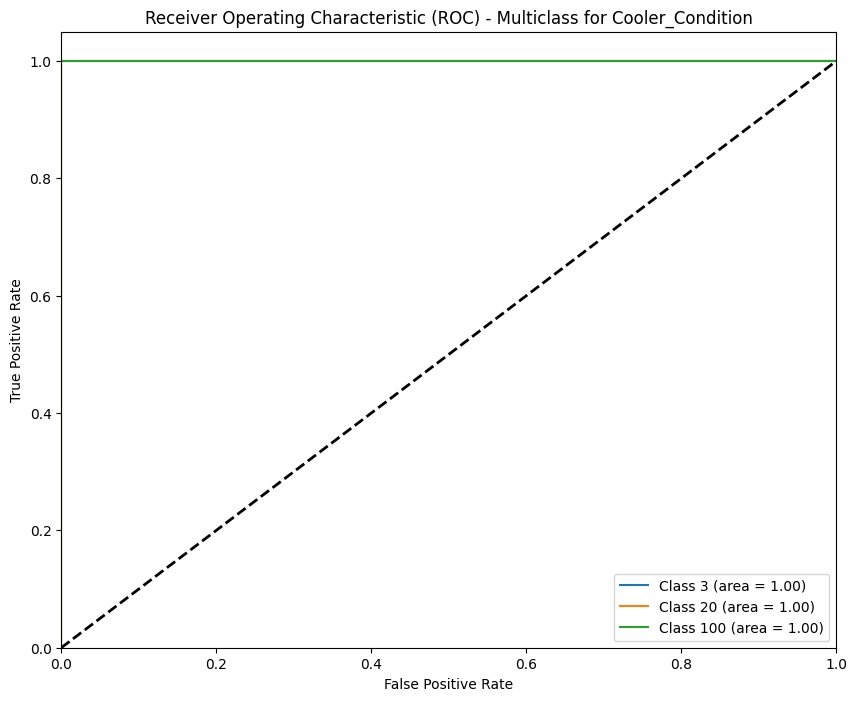

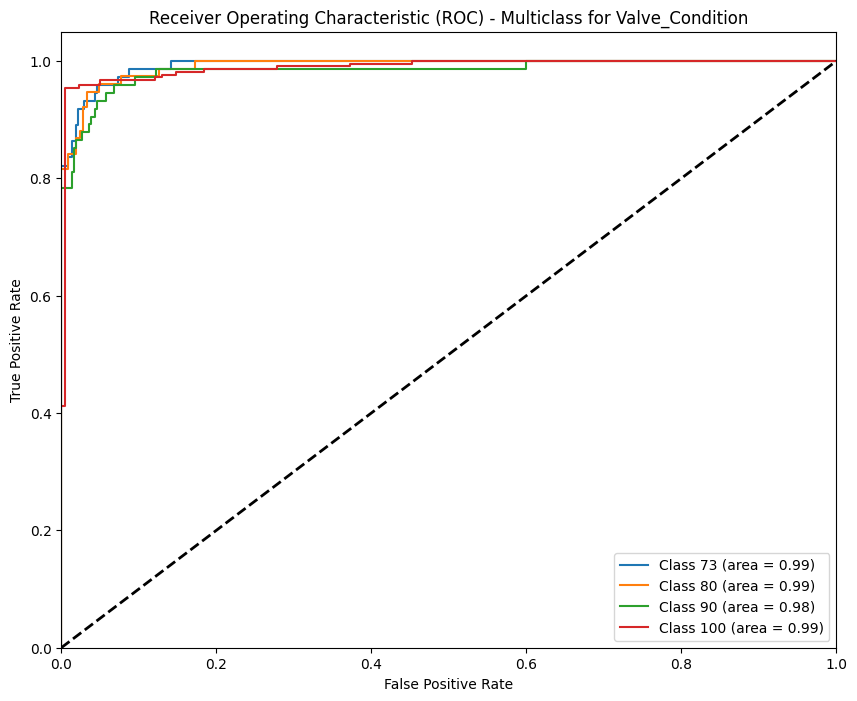

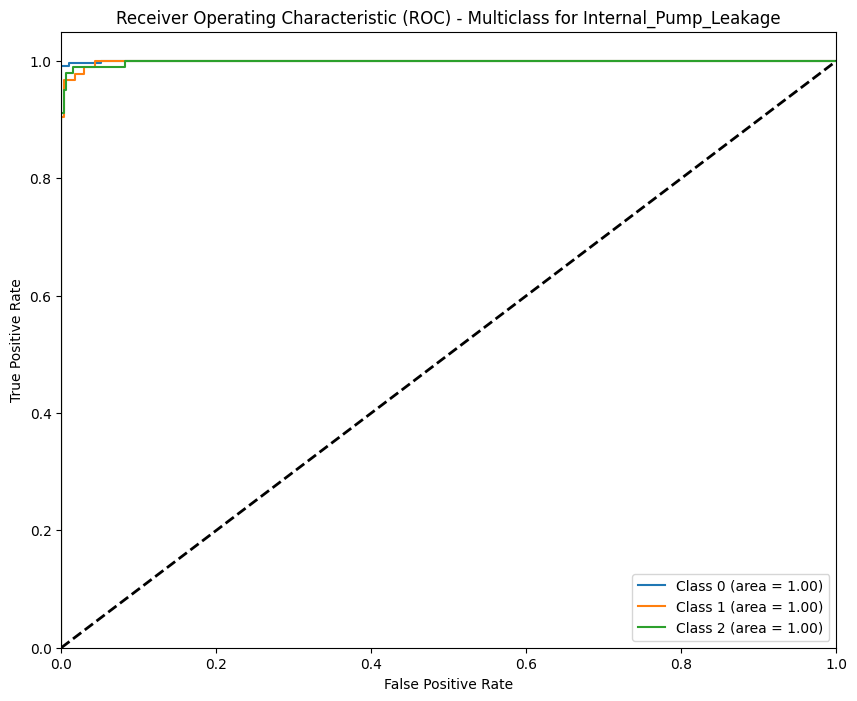

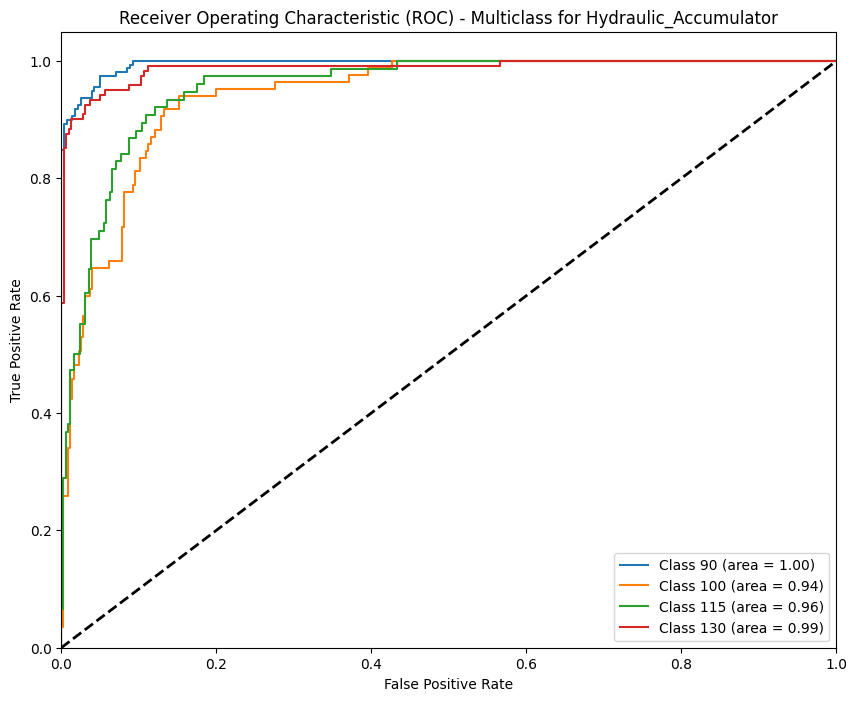

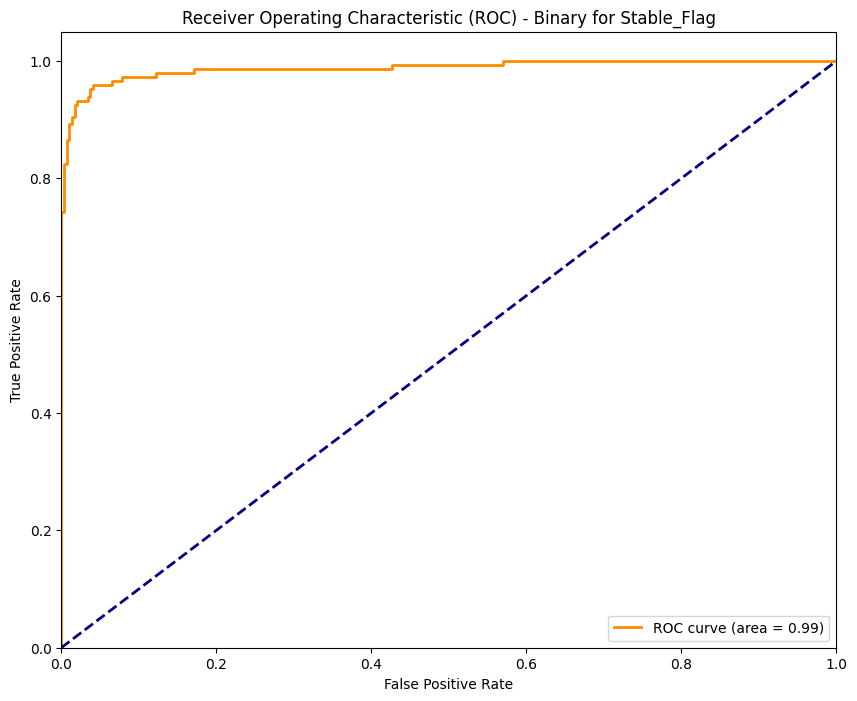


#------------------------------------------------------------------------------------------------------------------------------
# Features selected by Pearson / LSTM
#------------------------------------------------------------------------------------------------------------------------------


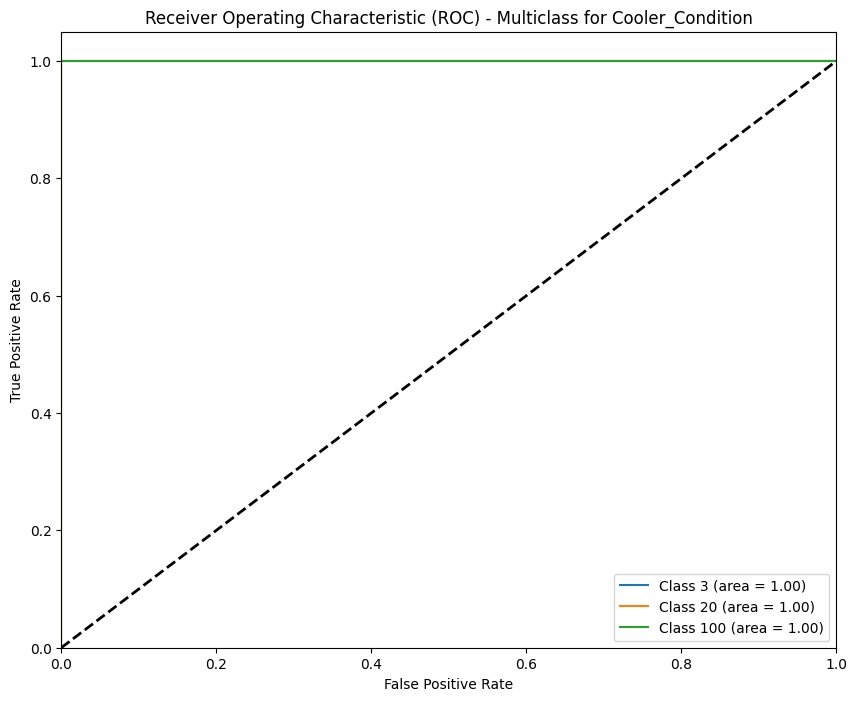

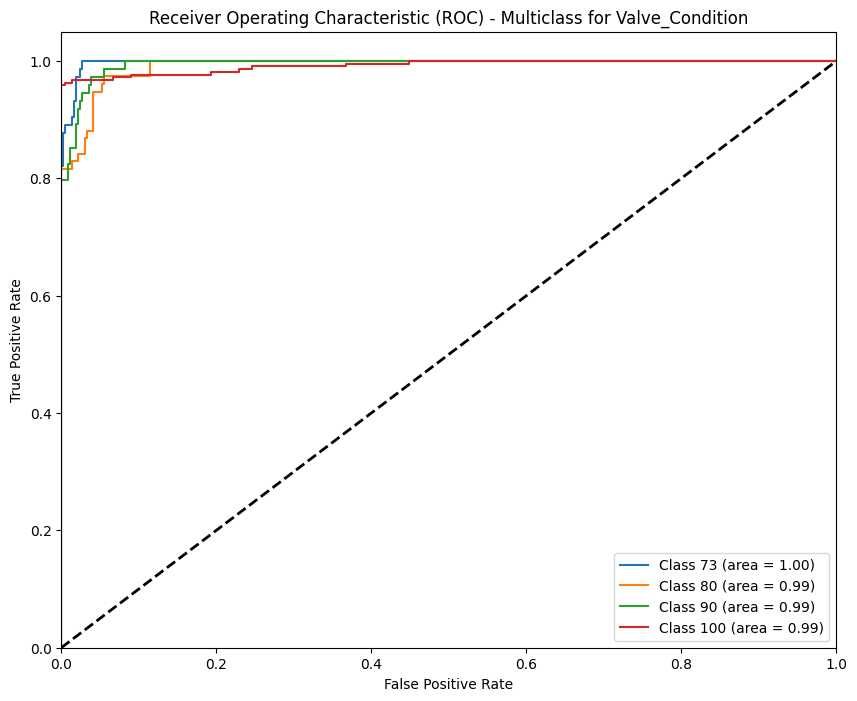

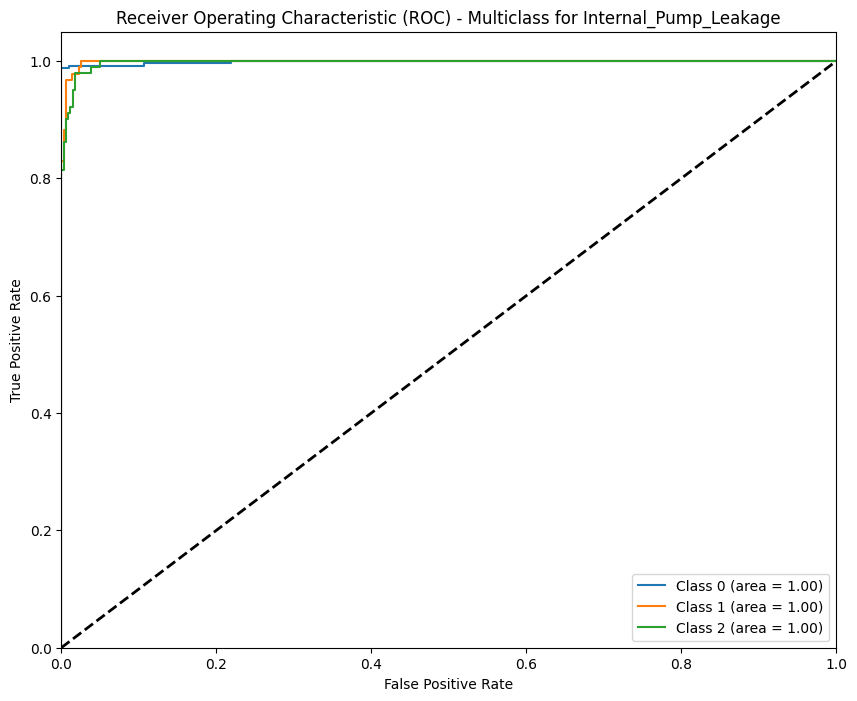

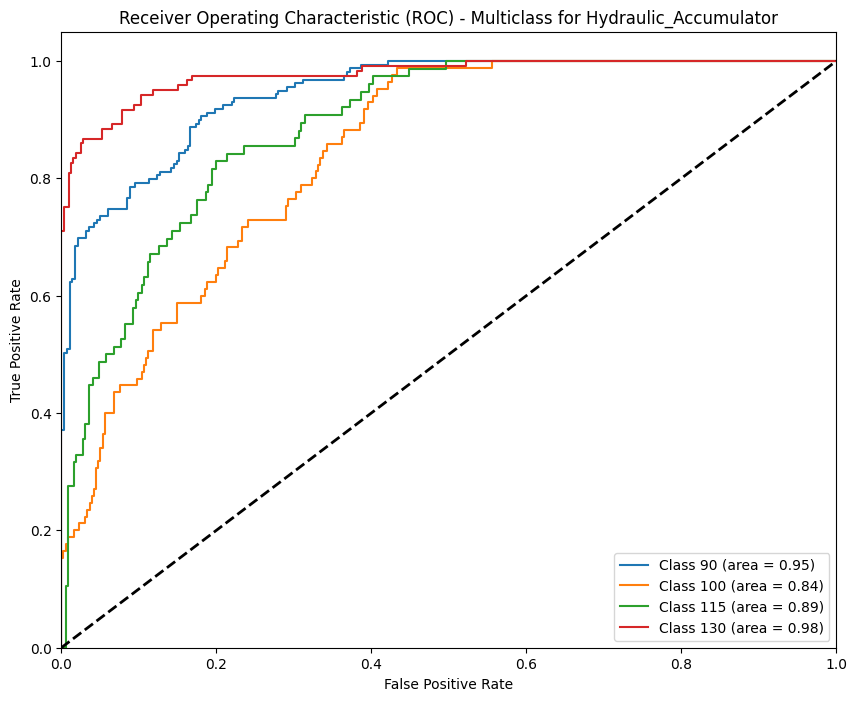

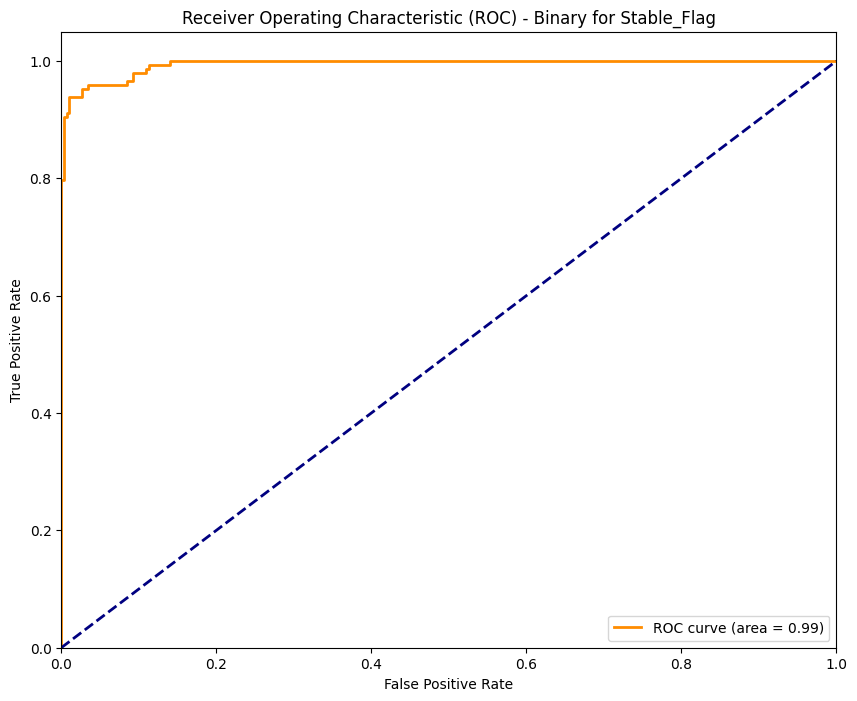


#------------------------------------------------------------------------------------------------------------------------------
# Features selected by LDA / LSTM
#------------------------------------------------------------------------------------------------------------------------------


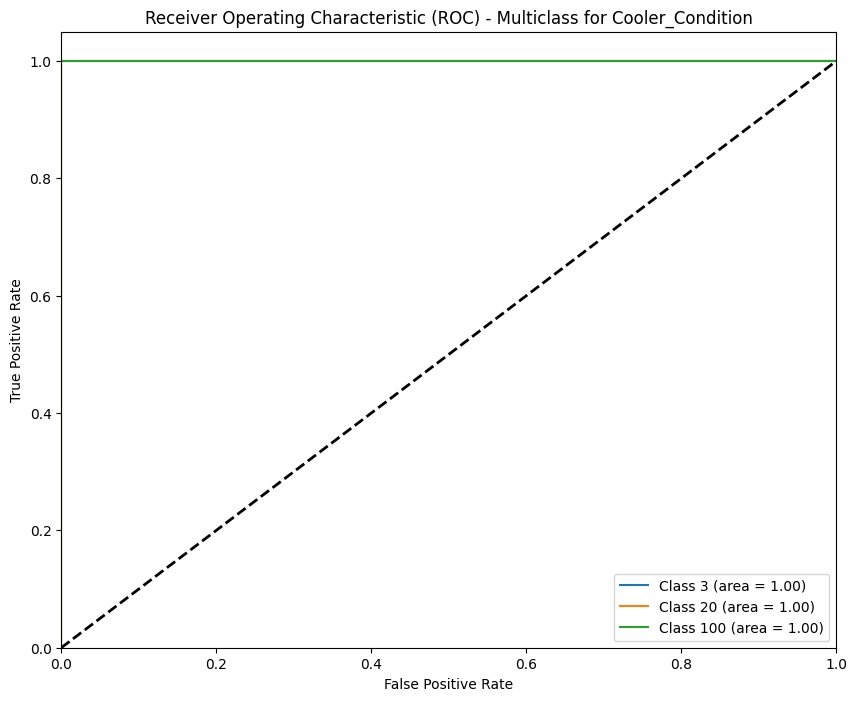

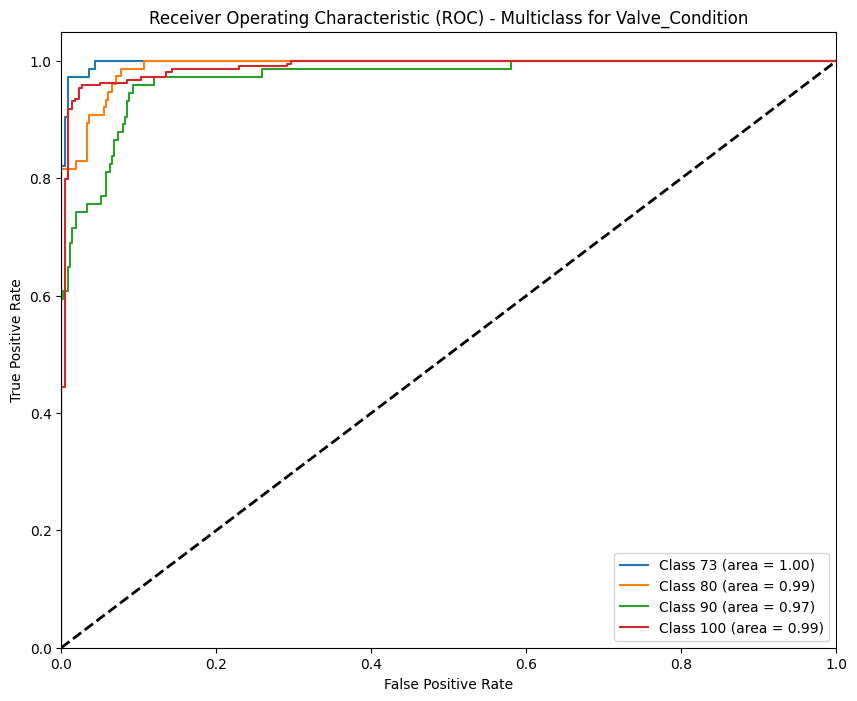

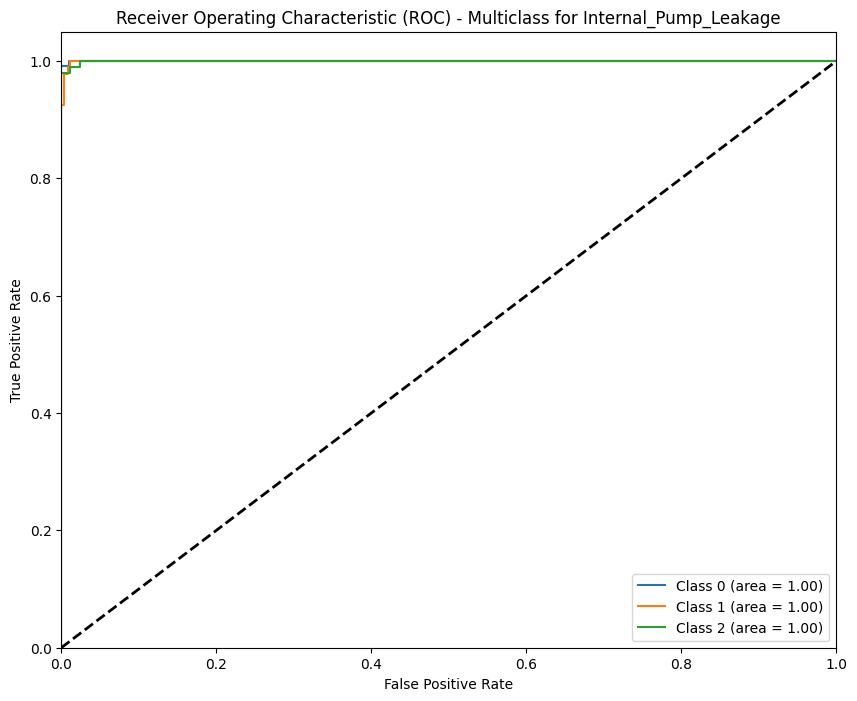

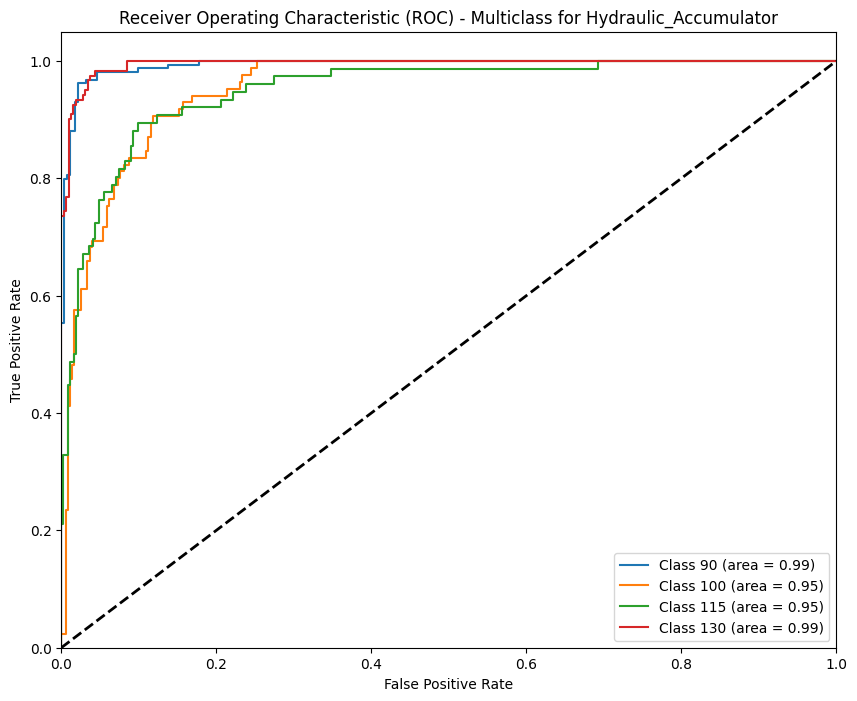

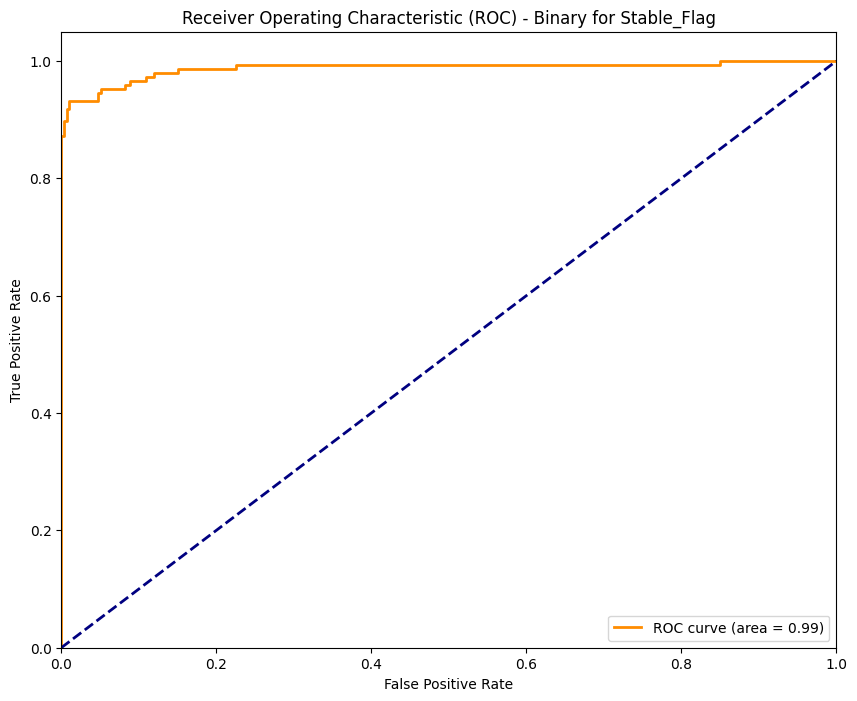

In [62]:
print('''
#------------------------------------------------------------------------------------------------------------------------------
# All Features / LSTM
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curvesLSTM(performance_metrics_dict_all)
print('''
#------------------------------------------------------------------------------------------------------------------------------
# Features selected by Pearson / LSTM
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curvesLSTM(performance_metrics_dict_pearson)
print('''
#------------------------------------------------------------------------------------------------------------------------------
# Features selected by LDA / LSTM
#------------------------------------------------------------------------------------------------------------------------------''')
plot_roc_curvesLSTM(performance_metrics_dict_lda)